In [2]:
# %load_ext rpy2.ipython 
# import vamb
%config IPCompleter.greedy=True
%config Completer.use_jedi=False
# %load_ext rpy2.ipython
%matplotlib inline


In [3]:
import pickle
import numpy as np
import pandas as pd
import os
import glob
import requests
# import xmltodict
import json
from itertools import compress
import re
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from Bio import SeqIO
plt.rcParams['figure.figsize'] = [10, 5]

In [4]:
%cd /home/gladkov2/storage/metagenome/rnf_c_new/
!ls -halt

/mnt/storage/metagenome/rnf_c_new
total 13M
drwxrwxr-x  2 gladkov2 gladkov2 4.0K Oct  8 21:47 catalases
-rw-rw-r--  1 gladkov2 gladkov2  19K Oct  8 21:24 al_01.fasta
drwxrwxr-x 10 gladkov2 gladkov2 4.0K Oct  8 21:24 .
-rw-rw-r--  1 gladkov2 gladkov2 1.7K Oct  8 20:09 test.fasta
-rw-rw-r--  1 gladkov2 gladkov2 1.7K Oct  8 20:06 test
drwxrwxr-x  2 gladkov2 gladkov2 4.0K Oct  8 12:18 filt_fastas
drwxrwxr-x  2 gladkov2 gladkov2 4.0K Oct  8 10:51 cat_fastas
drwxrwxr-x  2 gladkov2 gladkov2 4.0K Oct  6 12:19 cd-hit-out
drwxrwxr-x  2 gladkov2 gladkov2 4.0K Oct  6 09:31 anno
drwxrwxr-x  2 gladkov2 gladkov2 4.0K Oct  3 06:14 dbcan3
-rw-rw-r--  1 gladkov2 gladkov2 3.7M Oct  3 05:57 test_ori.fasta
-rw-rw-r--  1 gladkov2 gladkov2 3.8M Aug 23 09:44 test_res.fasta
-rw-rw-r--  1 gladkov2 gladkov2  16K Aug 19 14:19 maft.fasta
-rw-rw-r--  1 gladkov2 gladkov2 1.6M Aug 19 14:11 C1_hits_1
-rw-rw-r--  1 gladkov2 gladkov2  83K Aug 19 14:11 C1_hits_1.clstr
-rw-rw-r--  1 gladkov2 gladkov2    0 Aug 19 14:05 con

In [113]:
os.getcwd()

'/mnt/storage/metagenome/rnf_c_new'

## Functions

In [747]:
def keggRest(what, entry ="ORTHOLOGY"):
    HELP = ['ENTRY', 'NAME', 'CLASS', 'SYSNAME', 'REACTION', 'ALL_REAC', 'SUBSTRATE', 'PRODUCT', 'COMMENT', 'HISTORY', 'REFERENCE','PATHWAY', 'ORTHOLOGY', 'GENES', 'DBLINKS']
    if what.lower() == "help":
        print(HELP)
        return
    entry_l = []
    if isinstance(entry, str):
        entry_l.append(entry)
    if isinstance(entry, type([])):
        entry_l.extend(entry)      
    kr = requests.get(f"https://rest.kegg.jp/get/{what}")
    if kr.status_code != 200:
        print(f"ERROR {kr.status_code}")
        return
    l = kr.text.split("\n")
    res = [i[0] for i in enumerate(l) if i[1].startswith(tuple(entry_l))]
    for a in res:
        for num, line in [i for i in enumerate(l)][a:]:
            if num >= a:
                if (not num == a) and not line.startswith(" "):
                    break
                else:
                    print(line)
                    
 
# function do not work properly -- too slow on the "str.contain" procediure. Two solutions:
# parallelisation throught polars
# transform df_gll_object and solve problem without str methods
def add_split_conque(df_gff_l, query_list, postfix, add_number):
    df_gff_cat_ch = df_gff_l[df_gff_l["id"].str.contains('|'.join(query_list))]
    print(df_gff_cat_ch)
    df_gff_cat_ch['start'] = df_gff_cat_ch['start'] - add_number
    df_gff_cat_ch.loc[df_gff_cat_ch['start'] <= 0, 'start'] = 1 
    df_gff_cat_ch['end'] = df_gff_cat_ch['end'] + add_number
    df_gff_cat_ch.loc[df_gff_cat_ch['end'] > df_gff_cat_ch['contig_len'], 'end'] = df_gff_cat_ch['contig_len'] - 1
    datas = {}
    for i, g in df_gff_cat_ch.groupby('site'):
        datas.update({'data_' + str(i) : g.reset_index(drop=True)})
    for k, v in datas.items():
        v = v.drop(['site', 'id'], axis=1)
        v.to_csv(f'filt_gffs/{k.split("_")[1]}_{postfix}.gff', index=False, header=False, sep="\t")
        


In [647]:
df_gff_l.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7243976 entries, 0 to 7243975
Data columns (total 12 columns):
 #   Column      Dtype  
---  ------      -----  
 0   seqid       object 
 1   source      object 
 2   type        object 
 3   start       int64  
 4   end         int64  
 5   score       float64
 6   strand      object 
 7   phase       object 
 8   attributes  object 
 9   site        object 
 10  id          object 
 11  contig_len  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 718.5+ MB


In [763]:
def fastas_from_clusters(dir_out, prefix):
    files = sorted(glob.glob(f"{os.getcwd()}/cd-hit-out/*_{prefix}.clstr"))
    names = [os.path.basename(i).split(".")[0] for i in files]
    file_list = list(zip(names, files))
    files_into = sorted(glob.glob(f"{os.getcwd()}/filt_fastas/*"))
    counter = 0
    for i in file_list:
        d = {}
        buff = []
        clstr_file = i[1]
        with open(clstr_file) as clstr:
            for cl in clstr.readlines():
                a = cl.rstrip() 
                if cl.startswith(">"):
                    d[a] = []
                    buff.append(a)
                else:
                    d[buff[-1]].append(a)

        d_moreone = {}
        for k, v in d.items():
            if len(v) > 1:
                d_moreone.update({k : v})

        l_count = []
        for k, v in d.items():
            l_count.append(len(v))
        big_cluster = sorted(d_moreone.items(), key=lambda x: len(x[1]), reverse=True)[:3]
        big_cluster = dict(big_cluster)
        for keys, values in big_cluster.items():
            with open(f'/mnt/storage/metagenome/rnf_c_new/{dir_out}/{prefix}_{i[0].split("_")[0]}_{keys.split(" ")[1]}.fasta', 'a') as result:
                for listed_result_for_cluster in values:
                    m = re.search('nt\,\ (.+?)\.', listed_result_for_cluster)
                    if m:
                        found = m.group(1)
                        records = SeqIO.parse(files_into[counter], 'fasta')
                        for record in records:
                            if record.id in found:
                                result.write(record.format('fasta'))
        counter += 1

## Rename shit fastas

In [114]:
!head -n 250 ../rnf_c/copy_fastas/C2.fasta > test_ori.fasta

In [60]:
!rm ../rnf_c/fastas/C2.fasta

In [94]:
original_file = f'/mnt/storage/metagenome/rnf_c/copy_fastas/C2.fasta'
corrected_file = f'/mnt/storage/metagenome/rnf_c/fastas/C2.fasta'

In [86]:
original_file = f'/mnt/storage/metagenome/rnf_c_new/test_ori.fasta'
corrected_file = f'/mnt/storage/metagenome/rnf_c_new/test_res.fasta'

In [95]:
with open(original_file) as original, open(corrected_file, 'w') as corrected:
    records = SeqIO.parse(original_file, 'fasta')
    for record in enumerate(records):
        record[1].id = f'contig_{record[0]}'
        record[1].description = f'contig_{record[0]}'
        SeqIO.write(record[1], corrected, 'fasta' )


In [96]:
!grep ">" ../rnf_c/fastas/C2.fasta | head

>contig_0
>contig_1
>contig_2
>contig_3
>contig_4
>contig_5
>contig_6
>contig_7
>contig_8
>contig_9
grep: write error: Broken pipe


In [89]:
!grep ">" test_ori.fasta

>contig_1:1.0-40241.0
>contig_10:1.0-1787.0
>contig_100:1.0-2435.0
>contig_1000:1.0-133855.0
>contig_10001:1.0-29871.0
>contig_10002:1.0-60370.0
>contig_10003:1.0-4618.0
>contig_10004:1.0-8965.0
>contig_10005:1.0-20131.0
>contig_10006:1.0-12146.0
>contig_10007:1.0-10561.0
>contig_10008:1.0-5602.0
>contig_10009:502.0-5949.0
>contig_10010:1.0-176242.0
>contig_10011:1.0-10470.0
>contig_10012:1.0-25784.0
>contig_10013:1.0-19839.0
>contig_10014:1.0-4926.0
>contig_10015:1.0-21744.0
>contig_10016:1.0-11580.0
>contig_10017:1.0-10335.0
>contig_10018:1.0-1643.0
>contig_1002:1.0-209931.0
>contig_10020:1.0-15123.0
>contig_10020:15417.0-18956.0
>contig_10020:19144.0-23321.0
>contig_10020:23384.0-34590.0
>contig_10021:1.0-15231.0
>contig_10023:1.0-9577.0
>contig_10024:1.0-16535.0
>contig_10025:1.0-16037.0
>contig_10026:1.0-3619.0
>contig_10028:1.0-38158.0
>contig_10029:1.0-31913.0
>contig_10029:32182.0-44231.0
>contig_1003:1.0-4631.0
>contig_10030:1.0-15885.0
>contig_10031:1.0-8899.0
>contig_10032:1

## Annotation

In [303]:
files = sorted(glob.glob(f"{os.getcwd()}/anno/*.emapper.annotations"))
names = [os.path.basename(i).split(".")[0] for i in files]
file_list = list(zip(names, files))
header = pd.read_csv(file_list[1][1],sep="\t", skiprows=4 ,nrows=0).columns.to_list()
dfs = [pd.read_csv(f[1], sep="\t", comment="#", header=None, names=header).assign(site=f[0]) for f in file_list]
df = pd.concat(dfs, ignore_index=True)

In [304]:
df.columns

Index(['#query', 'seed_ortholog', 'evalue', 'score', 'eggNOG_OGs',
       'max_annot_lvl', 'COG_category', 'Description', 'Preferred_name', 'GOs',
       'EC', 'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction',
       'KEGG_rclass', 'BRITE', 'KEGG_TC', 'CAZy', 'BiGG_Reaction', 'PFAMs',
       'site'],
      dtype='object')

In [305]:
pd.set_option('display.max_columns', None)
df.head()

,#query,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,EC,KEGG_ko,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs,site
0,contig_1_0,700598.Niako_5238,0.000000e+00,1404.0,"COG1629@1|root,COG1629@2|Bacteria,4NDXS@976|Ba...",976|Bacteroidetes,P,CarboxypepD_reg-like domain,-,-,-,-,-,-,-,-,-,-,-,-,"CarbopepD_reg_2,Plug,TonB_dep_Rec",C1
1,contig_1_3,700598.Niako_5237,4.340000e-255,790.0,"COG1435@1|root,COG1435@2|Bacteria,4NHCM@976|Ba...",976|Bacteroidetes,F,SusD family,-,-,-,ko:K21572,-,-,-,-,"ko00000,ko02000","8.A.46.1,8.A.46.3",-,-,"SusD-like_3,SusD_RagB",C1
2,contig_1_6,700598.Niako_5236,3.420000e-155,503.0,"28IBC@1|root,2Z8DV@2|Bacteria,4NQRQ@976|Bacter...",976|Bacteroidetes,S,Domain of unknown function (DUF5018),-,-,-,-,-,-,-,-,-,-,-,-,DUF5018,C1
3,contig_1_5,700598.Niako_5235,2.440000e-198,623.0,"COG1649@1|root,COG1649@2|Bacteria,4PHU5@976|Ba...",976|Bacteroidetes,S,Domain of unknown function,-,-,-,-,-,-,-,-,-,-,-,-,"DUF4985,GHL10",C1
4,contig_1_8,714943.Mucpa_2717,3.390000e-110,364.0,"COG4632@1|root,COG4632@2|Bacteria,4NR1M@976|Ba...",976|Bacteroidetes,G,COGs COG4632 Exopolysaccharide biosynthesis pr...,-,-,-,-,-,-,-,-,-,-,-,-,"Metallophos,NAGPA,fn3",C1


In [306]:
df = df.replace('-', np.nan)

In [307]:
(df.count() / df.count()[0] * 100).round()

#query            100.0
seed_ortholog     100.0
evalue            100.0
score             100.0
eggNOG_OGs        100.0
max_annot_lvl     100.0
COG_category       93.0
Description        93.0
Preferred_name     31.0
GOs                 8.0
EC                 26.0
KEGG_ko            51.0
KEGG_Pathway       30.0
KEGG_Module        20.0
KEGG_Reaction      20.0
KEGG_rclass        20.0
BRITE              51.0
KEGG_TC            11.0
CAZy                1.0
BiGG_Reaction       1.0
PFAMs              91.0
site              100.0
dtype: float64

In [262]:
mask = df.head(1000).Description.str.contains("ATPase", na=False)
mask

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996     True
997    False
998     True
999    False
Name: Description, Length: 1000, dtype: bool

In [308]:
df.shape[0]

7243957

In [366]:
df_cat = df[df.Description.str.contains("catalase", na=False)]

In [376]:
df_cat.groupby("KEGG_ko").count()["#query"].sort_values(ascending=False)

KEGG_ko
ko:K03782    1103
ko:K07217     412
ko:K03781     191
ko:K06334      32
Name: #query, dtype: int64

amazings re for and -- save for great future ```r'^(?=.*K03781)(?=.*K19885)'```

"1.11.1.6" -- for catalases -- that means ko ko:K03781,ko:K05520

In [309]:
df['id'] = df['site'] + "_" + df['#query'] 

In [50]:
df_cat_ko = df[df.KEGG_ko.str.contains("K03781|K19885", na=False)]

In [49]:
df_cat_ko.groupby("Description").count()["#query"].sort_values(ascending=False)

Description
Serves to protect cells from the toxic effects of hydrogen peroxide                                                             690
Catalase                                                                                                                        311
serves to protect cells from the toxic effects of hydrogen peroxide                                                             250
Belongs to the catalase family                                                                                                  178
Has an organic peroxide-dependent peroxidase activity                                                                           162
PFAM Catalase domain protein                                                                                                     22
Occurs in almost all aerobically respiring organisms and serves to protect cells from the toxic effects of hydrogen peroxide     18
COG0753 Catalase                                                

In [45]:
df_cat_ko.groupby("KEGG_ko").count()["#query"].sort_values(ascending=False)

KEGG_ko
ko:K03781                        1675
ko:K03781,ko:K05520                 3
ko:K03152,ko:K03781,ko:K05520       1
Name: #query, dtype: int64

In [47]:
df_cat_ko

,#query,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,EC,KEGG_ko,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs,site
672,contig_10014_255,717785.HYPMC_1555,2.450000e-223,694.0,"COG0753@1|root,COG0753@2|Bacteria,1MUXZ@1224|P...",28211|Alphaproteobacteria,P,serves to protect cells from the toxic effects...,NaN,NaN,1.11.1.6,ko:K03781,"ko00380,ko00630,ko01110,ko01130,ko01200,ko0401...",M00532,"R00009,R00602,R02670","RC00034,RC00767,RC02141,RC02755","ko00000,ko00001,ko00002,ko01000",NaN,NaN,NaN,Catalase,C1
2815,contig_10071_106,1005994.GTGU_04578,3.970000e-170,540.0,"COG0753@1|root,COG0753@2|Bacteria,1MUXZ@1224|P...",1236|Gammaproteobacteria,C,serves to protect cells from the toxic effects...,srpA,NaN,1.11.1.6,ko:K03781,"ko00380,ko00630,ko01110,ko01130,ko01200,ko0401...",M00532,"R00009,R00602,R02670","RC00034,RC00767,RC02141,RC02755","ko00000,ko00001,ko00002,ko01000",NaN,NaN,NaN,Catalase,C1
12680,contig_1031_0,1114964.L485_11740,0.000000e+00,1221.0,"COG0753@1|root,COG0753@2|Bacteria,1MUXZ@1224|P...",204457|Sphingomonadales,P,Serves to protect cells from the toxic effects...,NaN,NaN,1.11.1.6,ko:K03781,"ko00380,ko00630,ko01110,ko01130,ko01200,ko0401...",M00532,"R00009,R00602,R02670","RC00034,RC00767,RC02141,RC02755","ko00000,ko00001,ko00002,ko01000",NaN,NaN,NaN,"Catalase,Catalase-rel",C1
12765,contig_10321_2,365046.Rta_35880,0.000000e+00,1063.0,"COG0693@1|root,COG0753@1|root,COG0693@2|Bacter...",28216|Betaproteobacteria,C,Serves to protect cells from the toxic effects...,katE,NaN,1.11.1.6,ko:K03781,"ko00380,ko00630,ko01110,ko01130,ko01200,ko0401...",M00532,"R00009,R00602,R02670","RC00034,RC00767,RC02141,RC02755","ko00000,ko00001,ko00002,ko01000",NaN,NaN,NaN,"Catalase,Catalase-rel,DJ-1_PfpI",C1
12798,contig_10322_1,365046.Rta_35880,0.000000e+00,1068.0,"COG0693@1|root,COG0753@1|root,COG0693@2|Bacter...",28216|Betaproteobacteria,C,Serves to protect cells from the toxic effects...,katE,NaN,1.11.1.6,ko:K03781,"ko00380,ko00630,ko01110,ko01130,ko01200,ko0401...",M00532,"R00009,R00602,R02670","RC00034,RC00767,RC02141,RC02755","ko00000,ko00001,ko00002,ko01000",NaN,NaN,NaN,"Catalase,Catalase-rel,DJ-1_PfpI",C1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7214150,contig_98432_2,1385515.N791_11315,2.580000e-251,776.0,"COG0753@1|root,COG0753@2|Bacteria,1MUXZ@1224|P...",135614|Xanthomonadales,P,Serves to protect cells from the toxic effects...,NaN,NaN,1.11.1.6,ko:K03781,"ko00380,ko00630,ko01110,ko01130,ko01200,ko0401...",M00532,"R00009,R00602,R02670","RC00034,RC00767,RC02141,RC02755","ko00000,ko00001,ko00002,ko01000",NaN,NaN,NaN,"Catalase,Catalase-rel",L3
7227217,contig_99083_20,1403313.AXBR01000013_gene1305,2.470000e-19,104.0,"COG0753@1|root,COG0753@2|Bacteria,1TPPV@1239|F...",91061|Bacilli,P,serves to protect cells from the toxic effects...,katX,"GO:0000302,GO:0003674,GO:0003824,GO:0004096,GO...",1.11.1.6,ko:K03781,"ko00380,ko00630,ko01110,ko01130,ko01200,ko0401...",M00532,"R00009,R00602,R02670","RC00034,RC00767,RC02141,RC02755","ko00000,ko00001,ko00002,ko01000",NaN,NaN,NaN,"Catalase,Catalase-rel",L3
7227218,contig_99083_13,414684.RC1_2172,2.390000e-47,189.0,"COG0753@1|root,COG0753@2|Bacteria,1MUXZ@1224|P...",204441|Rhodospirillales,P,Catalase,NaN,NaN,1.11.1.6,ko:K03781,"ko00380,ko00630,ko01110,ko01130,ko01200,ko0401...",M00532,"R00009,R00602,R02670","RC00034,RC00767,RC02141,RC02755","ko00000,ko00001,ko00002,ko01000",NaN,NaN,NaN,"Catalase,Catalase-rel",L3
7233975,contig_99452_0,1120983.KB894576_gene3430,0.000000e+00,996.0,"COG0753@1|root,COG0753@2|Bacteria,1MUXZ@1224|P...",28211|Alphaproteobacteria,P,Catalase,katE,NaN,1.11.1.6,ko:K03781,"ko00380,ko00630,ko01110,ko01130,ko01200,ko0401...",M00532,"R00009,R00602,R02670","RC00034,RC00767,RC02141,RC02755","ko00000,ko00001,ko00002,ko01000",NaN,NaN,NaN,"Catalase,Catalase-rel",L3


In [51]:
query_cat_list = df_cat_ko["id"].to_list()

#### import gff

In [329]:
files = sorted(glob.glob(f"{os.getcwd()}/anno/*.emapper.genepred.gff"))
names = [os.path.basename(i).split(".")[0] for i in files]
file_list = list(zip(names, files))
header = ["seqid", "source", "type", "start", "end", "score", "strand", "phase", "attributes"]
df_gf_l = [pd.read_csv(f[1], sep="\t", comment="#", header=None, names=header).assign(site=f[0]) for f in file_list]
df_gff = pd.concat(df_gf_l, ignore_index=True)

In [330]:
cat_col_id = df_gff["attributes"].str.extract(r'(?<=ID=)(.*)(?=;em_target)')
df_gff["id"] = cat_col_id


In [331]:
df_gff['id'] = df_gff['site'] + "_" +df_gff['id']

In [55]:
df_gff_cat = df_gff[df_gff["id"].str.contains('|'.join(query_cat_list))]

In [56]:
df_gff_cat_ch = df_gff_cat.copy()


<AxesSubplot:ylabel='Count'>

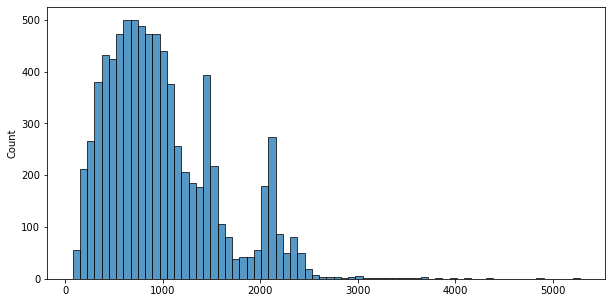

In [57]:
sns.histplot(df_gff_cat_ch['end'] - df_gff_cat_ch['start'])

## Add contig length

In [121]:
!infoseq -only -name -length -nocolumns -delimiter "\t" ../rnf_c/fastas/C2.fasta | tail -n 5

Display basic information about sequences
contig_71808	6538
contig_71809	585
contig_71810	15665
contig_71811	5383
contig_71812	5841


In [59]:
!grep ">" ../rnf_c/fastas/C2.fasta | head -n 10

>contig_0 contig_1:1.0-40241.0
>contig_1 contig_10:1.0-1787.0
>contig_2 contig_100:1.0-2435.0
>contig_3 contig_1000:1.0-133855.0
>contig_4 contig_10001:1.0-29871.0
>contig_5 contig_10002:1.0-60370.0
>contig_6 contig_10003:1.0-4618.0
>contig_7 contig_10004:1.0-8965.0
>contig_8 contig_10005:1.0-20131.0
>contig_9 contig_10006:1.0-12146.0
grep: write error: Broken pipe


In [723]:
%%bash

for file in ../rnf_c/fastas/*.fasta; do
#     mkdir len_contigs
    fname=$(basename "$file" .fasta)
    infoseq -only -name -length -nocolumns -delimiter "\t" ${file} > len_contigs/${fname}
done;


Display basic information about sequences
Display basic information about sequences
Display basic information about sequences
Display basic information about sequences
Display basic information about sequences
Display basic information about sequences


In [325]:
!cat len_contigs/C1 | head

Name           Length 
contig_66569   20861  
contig_23186   27871  
contig_46544   5729   
contig_52613   7121   
contig_15921   4037   
contig_19766   2939   
contig_64774   2811   
contig_41278   5755   
contig_5915    85425  
cat: write error: Broken pipe


In [724]:
files = sorted(glob.glob(f"{os.getcwd()}/len_contigs/*"))
names = [os.path.basename(i) for i in files]
file_list = list(zip(names, files))
dfs = [pd.read_csv(f[1], sep="\t", comment="#").assign(site=f[0]) for f in file_list]
df_len = pd.concat(dfs, ignore_index=True)

In [725]:
# df_len.rename({'Lenght':'lenght', 'id':'Name'} ,axis=1)
df_ln = df_len.rename(columns={'Length': 'contig_len', 'Name': 'seqid'})
# df_ln['id'] = df_ln['site'] + "_" +df_ln['seqid']

In [726]:
df_ln["contig_len"].describe().astype('int64')

count      458806
mean        21135
std         94433
min            49
25%          5039
50%          9669
75%         18383
max      12337315
Name: contig_len, dtype: int64

In [727]:
df_ln

,seqid,contig_len,site
0,contig_66569,20861,C1
1,contig_23186,27871,C1
2,contig_46544,5729,C1
3,contig_52613,7121,C1
4,contig_15921,4037,C1
...,...,...,...
458801,contig_16464,544,L3
458802,contig_49697,559,L3
458803,contig_27031,1042,L3
458804,contig_59389,752,L3


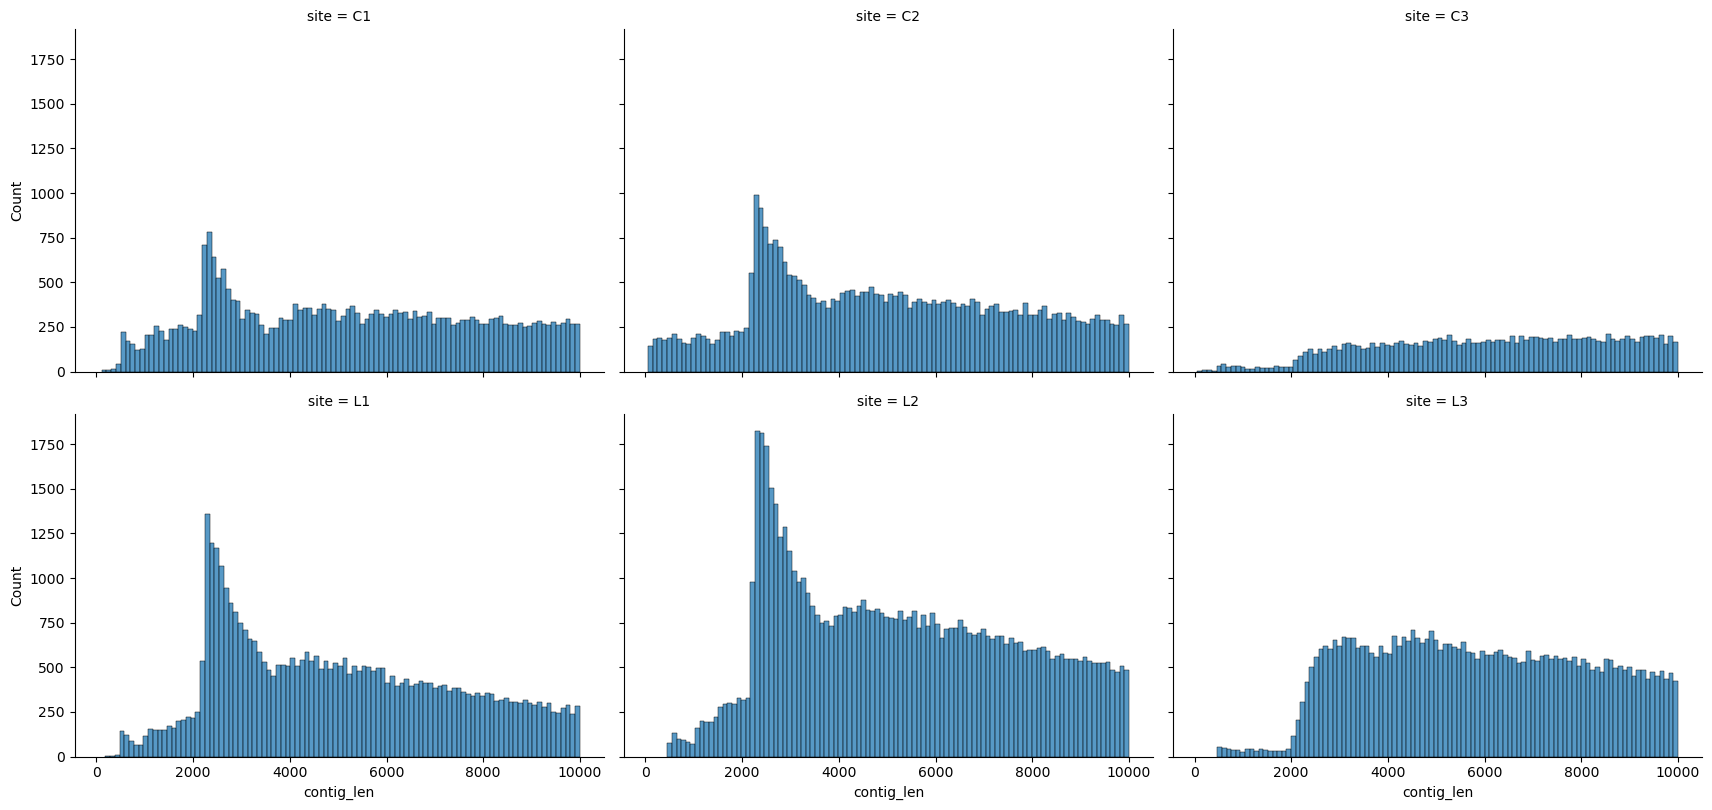

In [728]:
# plt.rcParams['figure.figsize'] = [25, 10]
g = sns.FacetGrid(df_ln[df_ln["contig_len"] < 10000], col="site", height=4.1, aspect=1.4, col_wrap=3)
g.map(sns.histplot, "contig_len", bins=100)

In [729]:
df_gff

,seqid,source,type,start,end,score,strand,phase,attributes,site,id
0,contig_1,eggNOG-mapper,CDS,13,3014,1404.0,+,.,ID=contig_1_0;em_target=700598.Niako_5238;em_s...,C1,C1_contig_1_0
1,contig_1,eggNOG-mapper,CDS,3035,4732,790.0,+,.,ID=contig_1_3;em_target=700598.Niako_5237;em_s...,C1,C1_contig_1_3
2,contig_1,eggNOG-mapper,CDS,4764,6449,503.0,+,.,ID=contig_1_6;em_target=700598.Niako_5236;em_s...,C1,C1_contig_1_6
3,contig_1,eggNOG-mapper,CDS,6466,7868,623.0,+,.,ID=contig_1_5;em_target=700598.Niako_5235;em_s...,C1,C1_contig_1_5
4,contig_1,eggNOG-mapper,CDS,7937,8956,364.0,+,.,ID=contig_1_8;em_target=714943.Mucpa_2717;em_s...,C1,C1_contig_1_8
...,...,...,...,...,...,...,...,...,...,...,...
7243971,contig_99999,eggNOG-mapper,CDS,30008,31816,560.0,+,.,ID=contig_99999_2;em_target=234267.Acid_3577;e...,L3,L3_contig_99999_2
7243972,contig_99999,eggNOG-mapper,CDS,32783,33290,213.0,+,.,ID=contig_99999_12;em_target=1267535.KB906767_...,L3,L3_contig_99999_12
7243973,contig_99999,eggNOG-mapper,CDS,33355,34500,357.0,+,.,ID=contig_99999_5;em_target=1185876.BN8_01972;...,L3,L3_contig_99999_5
7243974,contig_99999,eggNOG-mapper,CDS,39194,40450,474.0,-,.,ID=contig_99999_3;em_target=1089547.KB913013_g...,L3,L3_contig_99999_3


In [730]:
df_gff_l = df_gff.merge(df_ln, on=['seqid', 'site'] , how='left')

In [439]:
df_gff_l

,seqid,source,type,start,end,score,strand,phase,attributes,site,id,contig_len
0,contig_1,eggNOG-mapper,CDS,13,3014,1404.0,+,.,ID=contig_1_0;em_target=700598.Niako_5238;em_s...,C1,C1_contig_1_0,18772.0
1,contig_1,eggNOG-mapper,CDS,3035,4732,790.0,+,.,ID=contig_1_3;em_target=700598.Niako_5237;em_s...,C1,C1_contig_1_3,18772.0
2,contig_1,eggNOG-mapper,CDS,4764,6449,503.0,+,.,ID=contig_1_6;em_target=700598.Niako_5236;em_s...,C1,C1_contig_1_6,18772.0
3,contig_1,eggNOG-mapper,CDS,6466,7868,623.0,+,.,ID=contig_1_5;em_target=700598.Niako_5235;em_s...,C1,C1_contig_1_5,18772.0
4,contig_1,eggNOG-mapper,CDS,7937,8956,364.0,+,.,ID=contig_1_8;em_target=714943.Mucpa_2717;em_s...,C1,C1_contig_1_8,18772.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7243971,contig_99999,eggNOG-mapper,CDS,30008,31816,560.0,+,.,ID=contig_99999_2;em_target=234267.Acid_3577;e...,L3,L3_contig_99999_2,42177.0
7243972,contig_99999,eggNOG-mapper,CDS,32783,33290,213.0,+,.,ID=contig_99999_12;em_target=1267535.KB906767_...,L3,L3_contig_99999_12,42177.0
7243973,contig_99999,eggNOG-mapper,CDS,33355,34500,357.0,+,.,ID=contig_99999_5;em_target=1185876.BN8_01972;...,L3,L3_contig_99999_5,42177.0
7243974,contig_99999,eggNOG-mapper,CDS,39194,40450,474.0,-,.,ID=contig_99999_3;em_target=1089547.KB913013_g...,L3,L3_contig_99999_3,42177.0


### chage it in future

In [487]:
df_gff_l = df_gff_l.dropna()
df_gff_l['contig_len'] = df_gff_l['contig_len'].astype('int64')

In [440]:
df_gff_l["site"].unique()

array(['C1', 'C2', 'C3', 'L1', 'L2', 'L3'], dtype=object)

In [492]:
df_gff_cat_ch

,seqid,source,type,start,end,score,strand,phase,attributes,site,id
672,contig_10014,eggNOG-mapper,CDS,417939,418986,694.0,+,.,ID=contig_10014_255;em_target=717785.HYPMC_155...,C1,C1_contig_10014_255
2815,contig_10071,eggNOG-mapper,CDS,78620,79661,540.0,-,.,ID=contig_10071_106;em_target=1005994.GTGU_045...,C1,C1_contig_10071_106
12680,contig_1031,eggNOG-mapper,CDS,22130,24274,1221.0,-,.,ID=contig_1031_0;em_target=1114964.L485_11740;...,C1,C1_contig_1031_0
12755,contig_10321,eggNOG-mapper,CDS,1667,2296,317.0,-,.,ID=contig_10321_22;em_target=365046.Rta_35780;...,C1,C1_contig_10321_22
12758,contig_10321,eggNOG-mapper,CDS,4261,4911,323.0,-,.,ID=contig_10321_21;em_target=365046.Rta_35810;...,C1,C1_contig_10321_21
...,...,...,...,...,...,...,...,...,...,...,...
7214168,contig_98432,eggNOG-mapper,CDS,12449,13885,776.0,+,.,ID=contig_98432_2;em_target=1385515.N791_11315...,L3,L3_contig_98432_2
7227235,contig_99083,eggNOG-mapper,CDS,9964,10154,104.0,+,.,ID=contig_99083_20;em_target=1403313.AXBR01000...,L3,L3_contig_99083_20
7227236,contig_99083,eggNOG-mapper,CDS,10165,10500,189.0,+,.,ID=contig_99083_13;em_target=414684.RC1_2172;e...,L3,L3_contig_99083_13
7233994,contig_99452,eggNOG-mapper,CDS,42078,44142,996.0,-,.,ID=contig_99452_0;em_target=1120983.KB894576_g...,L3,L3_contig_99452_0


In [534]:
df_gff_cat_ch = df_gff_l[df_gff["id"].str.contains('|'.join(query_cat_list))]

<ipython-input-534-30a0b5480268>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_gff_cat_ch = df_gff_l[df_gff["id"].str.contains('|'.join(query_cat_list))]


In [496]:
df_gff_cat_ch

,seqid,source,type,start,end,score,strand,phase,attributes,site,id,contig_len
672,contig_10014,eggNOG-mapper,CDS,417939,418986,694.0,+,.,ID=contig_10014_255;em_target=717785.HYPMC_155...,C1,C1_contig_10014_255,997037
2815,contig_10071,eggNOG-mapper,CDS,78620,79661,540.0,-,.,ID=contig_10071_106;em_target=1005994.GTGU_045...,C1,C1_contig_10071_106,314532
12680,contig_1031,eggNOG-mapper,CDS,22130,24274,1221.0,-,.,ID=contig_1031_0;em_target=1114964.L485_11740;...,C1,C1_contig_1031_0,31750
12755,contig_10321,eggNOG-mapper,CDS,1667,2296,317.0,-,.,ID=contig_10321_22;em_target=365046.Rta_35780;...,C1,C1_contig_10321_22,41565
12758,contig_10321,eggNOG-mapper,CDS,4261,4911,323.0,-,.,ID=contig_10321_21;em_target=365046.Rta_35810;...,C1,C1_contig_10321_21,41565
...,...,...,...,...,...,...,...,...,...,...,...,...
7214168,contig_98432,eggNOG-mapper,CDS,12449,13885,776.0,+,.,ID=contig_98432_2;em_target=1385515.N791_11315...,L3,L3_contig_98432_2,14911
7227235,contig_99083,eggNOG-mapper,CDS,9964,10154,104.0,+,.,ID=contig_99083_20;em_target=1403313.AXBR01000...,L3,L3_contig_99083_20,22195
7227236,contig_99083,eggNOG-mapper,CDS,10165,10500,189.0,+,.,ID=contig_99083_13;em_target=414684.RC1_2172;e...,L3,L3_contig_99083_13,22195
7233994,contig_99452,eggNOG-mapper,CDS,42078,44142,996.0,-,.,ID=contig_99452_0;em_target=1120983.KB894576_g...,L3,L3_contig_99452_0,48985


In [535]:

df_gff_cat_ch['start'] = df_gff_cat_ch['start'] - 50 
df_gff_cat_ch.loc[df_gff_cat_ch['start'] <= 0, 'start'] = 1
df_gff_cat_ch['end'] = df_gff_cat_ch['end'] + 50
df_gff_cat_ch.loc[df_gff_cat_ch['end'] > df_gff_cat_ch['contig_len'], 'end'] = df_gff_cat_ch['contig_len']
df_gff_cat_ch


<ipython-input-535-b7c6eac988f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gff_cat_ch['start'] = df_gff_cat_ch['start'] - 50
/home/gladkov2/anaconda3/envs/vamb/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-535-b7c6eac988f5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

,seqid,source,type,start,end,score,strand,phase,attributes,site,id,contig_len
672,contig_10014,eggNOG-mapper,CDS,417889,419036,694.0,+,.,ID=contig_10014_255;em_target=717785.HYPMC_155...,C1,C1_contig_10014_255,997037
2815,contig_10071,eggNOG-mapper,CDS,78570,79711,540.0,-,.,ID=contig_10071_106;em_target=1005994.GTGU_045...,C1,C1_contig_10071_106,314532
12680,contig_1031,eggNOG-mapper,CDS,22080,24324,1221.0,-,.,ID=contig_1031_0;em_target=1114964.L485_11740;...,C1,C1_contig_1031_0,31750
12755,contig_10321,eggNOG-mapper,CDS,1617,2346,317.0,-,.,ID=contig_10321_22;em_target=365046.Rta_35780;...,C1,C1_contig_10321_22,41565
12758,contig_10321,eggNOG-mapper,CDS,4211,4961,323.0,-,.,ID=contig_10321_21;em_target=365046.Rta_35810;...,C1,C1_contig_10321_21,41565
...,...,...,...,...,...,...,...,...,...,...,...,...
7214168,contig_98432,eggNOG-mapper,CDS,12399,13935,776.0,+,.,ID=contig_98432_2;em_target=1385515.N791_11315...,L3,L3_contig_98432_2,14911
7227235,contig_99083,eggNOG-mapper,CDS,9914,10204,104.0,+,.,ID=contig_99083_20;em_target=1403313.AXBR01000...,L3,L3_contig_99083_20,22195
7227236,contig_99083,eggNOG-mapper,CDS,10115,10550,189.0,+,.,ID=contig_99083_13;em_target=414684.RC1_2172;e...,L3,L3_contig_99083_13,22195
7233994,contig_99452,eggNOG-mapper,CDS,42028,44192,996.0,-,.,ID=contig_99452_0;em_target=1120983.KB894576_g...,L3,L3_contig_99452_0,48985


In [536]:
datas = {}
for i, g in df_gff_cat_ch.groupby('site'):
    datas.update({'data_' + str(i) : g.reset_index(drop=True)})

In [501]:
%mkdir filt_gffs

mkdir: cannot create directory ‘filt_gffs’: File exists


In [537]:
for k, v in datas.items():
    v = v.drop(['site', 'id'], axis=1)
    v.to_csv(f'filt_gffs/{k.split("_")[1]}_cat.gff', index=False, header=False, sep="\t")
    

In [503]:
datas['data_C1']

,seqid,source,type,start,end,score,strand,phase,attributes,site,id,contig_len
0,contig_10014,eggNOG-mapper,CDS,417889,997037,694.0,+,.,ID=contig_10014_255;em_target=717785.HYPMC_155...,C1,C1_contig_10014_255,997037
1,contig_10071,eggNOG-mapper,CDS,78570,314532,540.0,-,.,ID=contig_10071_106;em_target=1005994.GTGU_045...,C1,C1_contig_10071_106,314532
2,contig_1031,eggNOG-mapper,CDS,22080,31750,1221.0,-,.,ID=contig_1031_0;em_target=1114964.L485_11740;...,C1,C1_contig_1031_0,31750
3,contig_10321,eggNOG-mapper,CDS,1617,41565,317.0,-,.,ID=contig_10321_22;em_target=365046.Rta_35780;...,C1,C1_contig_10321_22,41565
4,contig_10321,eggNOG-mapper,CDS,4211,41565,323.0,-,.,ID=contig_10321_21;em_target=365046.Rta_35810;...,C1,C1_contig_10321_21,41565
...,...,...,...,...,...,...,...,...,...,...,...,...
1596,contig_9416,eggNOG-mapper,CDS,12163,37501,1059.0,+,.,ID=contig_9416_0;em_target=1121013.P873_10935;...,C1,C1_contig_9416_0,37501
1597,contig_9744,eggNOG-mapper,CDS,5218,10329,1154.0,-,.,ID=contig_9744_0;em_target=1040987.AZUY0100005...,C1,C1_contig_9744_0,10329
1598,contig_98,eggNOG-mapper,CDS,23967,196001,1027.0,+,.,ID=contig_98_17;em_target=717785.HYPMC_0923;em...,C1,C1_contig_98_17,196001
1599,contig_9800,eggNOG-mapper,CDS,30776,66674,211.0,-,.,ID=contig_9800_35;em_target=1356854.N007_12360...,C1,C1_contig_9800_35,66674


In [168]:
df_gff_cat_ch

,seqid,source,type,start,end,score,strand,phase,attributes,site,id
672,contig_10014,eggNOG-mapper,CDS,417939,418986,694.0,+,.,ID=contig_10014_255;em_target=717785.HYPMC_155...,C1,C1_contig_10014_255
2815,contig_10071,eggNOG-mapper,CDS,78620,79661,540.0,-,.,ID=contig_10071_106;em_target=1005994.GTGU_045...,C1,C1_contig_10071_106
12680,contig_1031,eggNOG-mapper,CDS,22130,24274,1221.0,-,.,ID=contig_1031_0;em_target=1114964.L485_11740;...,C1,C1_contig_1031_0
12755,contig_10321,eggNOG-mapper,CDS,1667,2296,317.0,-,.,ID=contig_10321_22;em_target=365046.Rta_35780;...,C1,C1_contig_10321_22
12758,contig_10321,eggNOG-mapper,CDS,4261,4911,323.0,-,.,ID=contig_10321_21;em_target=365046.Rta_35810;...,C1,C1_contig_10321_21
...,...,...,...,...,...,...,...,...,...,...,...
7214168,contig_98432,eggNOG-mapper,CDS,12449,13885,776.0,+,.,ID=contig_98432_2;em_target=1385515.N791_11315...,L3,L3_contig_98432_2
7227235,contig_99083,eggNOG-mapper,CDS,9964,10154,104.0,+,.,ID=contig_99083_20;em_target=1403313.AXBR01000...,L3,L3_contig_99083_20
7227236,contig_99083,eggNOG-mapper,CDS,10165,10500,189.0,+,.,ID=contig_99083_13;em_target=414684.RC1_2172;e...,L3,L3_contig_99083_13
7233994,contig_99452,eggNOG-mapper,CDS,42078,44142,996.0,-,.,ID=contig_99452_0;em_target=1120983.KB894576_g...,L3,L3_contig_99452_0


In [525]:
strange_contig = df[df["#query"].str.contains("contig_10014", na=False)]

In [526]:
strange_contig_cat = strange_contig[strange_contig.KEGG_ko.str.contains("K03781|K19885", na=False)]

In [527]:
strange_contig_cat

,#query,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,...,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs,site,id
672,contig_10014_255,717785.HYPMC_1555,2.450000e-223,694.0,"COG0753@1|root,COG0753@2|Bacteria,1MUXZ@1224|P...",28211|Alphaproteobacteria,P,serves to protect cells from the toxic effects...,NaN,NaN,...,M00532,"R00009,R00602,R02670","RC00034,RC00767,RC02141,RC02755","ko00000,ko00001,ko00002,ko01000",NaN,NaN,NaN,Catalase,C1,C1_contig_10014_255


In [529]:
!grep "contig_10014_255" anno/C1.emapper.genepred.gff

contig_10014	eggNOG-mapper	CDS	417939	418986	694.0	+	.	ID=contig_10014_255;em_target=717785.HYPMC_1555;em_score=694.0;em_evalue=2.45e-223;em_tcov=100.0;em_searcher=diamond


In [532]:
df_gff_cat_ch.loc[df_gff_cat_ch["id"] == "C1_contig_10014_255"]

,seqid,source,type,start,end,score,strand,phase,attributes,site,id,contig_len
672,contig_10014,eggNOG-mapper,CDS,417889,997037,694.0,+,.,ID=contig_10014_255;em_target=717785.HYPMC_155...,C1,C1_contig_10014_255,997037


In [442]:
def add_split_conque(df_gff_l, query_list, postfix,  add_number):
    df_gff_cat_ch = df_gff_l[df_gff_l["id"].str.contains('|'.join(query_list))]
    df_gff_cat_ch['start'] = df_gff_cat_ch['start'] - add_number
    df_gff_cat_ch.loc[df_gff_cat_ch['start'] <= 0, 'start'] = 1
    df_gff_cat_ch['end'] = df_gff_cat_ch['end'] + add_number
    df_gff_cat_ch.loc[df_gff_cat_ch['end'] > df_gff_cat_ch['contig_len'], 'end'] = df_gff_cat_ch['contig_len']
    datas = {}
    for i, g in df_gff_cat_ch.groupby('site'):
        datas.update({'data_' + str(i) : g.reset_index(drop=True)})
    for k, v in datas.items():
        v = v.drop(['site', 'id'], axis=1)
        v.to_csv(f'filt_gffs/{k.split("_")[1]}_{postfix}.gff', index=False, header=False, sep="\t")

## Bedtools -- env primer

```bedtools getfasta -fi  ../rnf_c/fastas/C1.fasta -bed filt_gffs/C1_cat.gff > filt_fastas/C1.fasta```
```cd-hit-est -i filt_fastas/C1.fasta -o C1_hits -c 0.8 -n 4 -T 32 -M 40000 -g 1 -d 0 -t 0 -r 1```

In [21]:
!ls --color

C1_hits          C1_hits_50.clstr          dbcan3       test_ori.fasta
C1_hits.clstr    C1_hits_sorted.clstr      filt_fastas  test_res.fasta
C1_hits_1        anno                      filt_gffs
C1_hits_1.clstr  cd-hit-out                len_contigs
C1_hits_50       contig_28705:20734-22753  maft.fasta


In [78]:
%mkdir cat_fastas

In [89]:
%rm /mnt/storage/metagenome/rnf_c_new/filt_fastas/{fname}.fasta

In [25]:
%%bash

for file in ../rnf_c/fastas/*.fasta; do
    fname=$(basename "$file" .fasta)
    bedtools getfasta -fi $file -bed filt_gffs/${fname}_cat.gff > filt_fastas/${fname}.fasta
    cd-hit-est -i filt_fastas/${fname}.fasta -o cd-hit-out/${fname} -c 0.8 -n 4 -T 32 -M 40000 -g 1 -d 0 -t 0 -r 1
done;


Program: CD-HIT, V4.8.1 (+OpenMP), Apr 07 2021, 10:57:21
Command: cd-hit-est -i filt_fastas/C1.fasta -o cd-hit-out/C1
         -c 0.8 -n 4 -T 32 -M 40000 -g 1 -d 0 -t 0 -r 1

Started: Thu Oct  6 11:10:33 2022
                            Output                              
----------------------------------------------------------------
total seq: 1601
longest and shortest : 3547 and 148
Total letters: 1677904
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 1M
Buffer          : 32 X 12M = 410M
Table           : 2 X 0M = 0M
Miscellaneous   : 0M
Total           : 412M

Table limit with the given memory limit:
Max number of representatives: 4000000
Max number of word counting entries: 4948486842

# comparing sequences from          0  to         47
---------- new table with       44 representatives
# comparing sequences from         47  to         92
...............---------- new table with       36 representatives
# comparing sequences from         

WARNING. chromosome (contig_10115:1.0-25128.0) was not found in the FASTA file. Skipping.
Error: malformed GFF entry at line 2. Coordinate detected that is < 1. Exiting.


Program: CD-HIT, V4.8.1 (+OpenMP), Apr 07 2021, 10:57:21
Command: cd-hit-est -i filt_fastas/C2.fasta -o cd-hit-out/C2
         -c 0.8 -n 4 -T 32 -M 40000 -g 1 -d 0 -t 0 -r 1

Started: Thu Oct  6 11:11:04 2022
                            Output                              
----------------------------------------------------------------
total seq: 0
longest and shortest : 0 and 18446744073709551615
Total letters: 0
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 0M
Buffer          : 32 X 12M = 385M
Table           : 2 X 0M = 0M
Miscellaneous   : 0M
Total           : 385M

Table limit with the given memory limit:
Max number of representatives: 4000000
Max number of word counting entries: 4951832320


        0  finished          0  clusters

Approximated maximum memory consumption: 385M
writing new database
writing clustering information
program completed !

Total CPU time 0.25
Program: CD-HIT, V4.8.1 (+OpenMP), Apr 07 2021, 10:57:21
Command: cd-hi

In [10]:
!infoseq -nocolumns -delimiter "\t" filt_fastas/C1.fasta | head -n 5

zsh:1: command not found: infoseq


In [539]:
!infoseq -only -name -length -nocolumns -delimiter "\t" filt_fastas/C1.fasta > test

Display basic information about sequences


<AxesSubplot:xlabel='Length', ylabel='Count'>

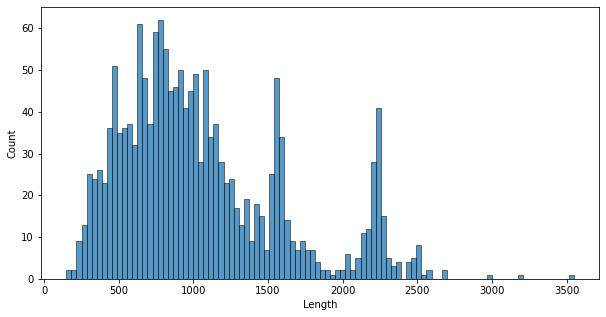

In [540]:

df_t = pd.read_csv('test', sep="\t")
sns.histplot(df_t["Length"], bins=100)


In [522]:
df_t.max

<bound method NDFrame._add_numeric_operations.<locals>.max of                Name  Length
0     417888-997037  579149
1      78569-314532  235963
2       22079-31750    9671
3        1616-41565   39949
4        4210-41565   37355
...             ...     ...
1596    12162-37501   25339
1597     5217-10329    5112
1598   23966-196001  172035
1599    30775-66674   35899
1600   46983-379909  332926

[1601 rows x 2 columns]>

In [ ]:
!grep ">" filt_fastas/C1.fasta | head -n 10

In [523]:
!grep "417888-997037" filt_fastas/C1.fasta | head -n 10

>contig_10014:417888-997037


In [27]:
!head -n 3 anno/C2.emapper.genepred.gff

##gff-version 3
## created with emapper-2.1.9
contig_10001:1.0-29871.0	eggNOG-mapper	CDS	1	495	211.0	-	.	ID=contig_10001:1.0-29871.0_22;em_target=666684.AfiDRAFT_1589;em_score=211.0;em_evalue=6.6e-53;em_tcov=21.0;em_searcher=diamond


In [46]:
!grep "contig_10001:1.0-29871.0_28" anno/C2.emapper.genepred.gff

contig_10001:1.0-29871.0	eggNOG-mapper	CDS	29744	29904	64.7	+	.	ID=contig_10001:1.0-29871.0_28;em_target=709797.CSIRO_1031;em_score=64.7;em_evalue=5.48e-07;em_tcov=16.7;em_searcher=diamond


In [50]:
29904 - 29744

160

In [52]:
!grep -B 2 "contig_10001:1.0-29871.0_28" anno/C2.emapper.genepred.fasta

>contig_10001:1.0-29871.0_23
GCTGGCGCAATCGCCGACGGCGGGCCGCACAGCTTCTCGGCCAGTTCGGAGATTGGGGCGCCTATACGGCCCGCCCGGCGGCAAGAAAATCTGCTTCGCCCTGGCCAAGCCAGCCACGTCCGAGACCAATCCGCCCAATCGCCCGCGTGATCCAGCCTGGTTCTTTGTGTCCACCCGGCCTGCCGAAAGGTGAAGGAAGAGGTTTCGGTCATCATCGGCTATCGTTCAAGGCGAACAGCGATGCCGTGGTCGAGATCGGCAGCACCAATTTGCCATGTACACGCAGAATGACGGCGCGTGGGTGAAGAACGCCGCCGAGGAAGCCCGGCTGATCGAGGCCATGCGGCGCGGCGCCGATGTAACGGTGCGGGGCAGATCGGCCGCGGCACCAAGACGACCGACCGCTTTTCGCTGAAGGGCGTTGCCCAGGCGCTCGACCGCGCCGCGCAGGAATGCCGG
>contig_10001:1.0-29871.0_28


In [49]:
!grep "contig_10001:1.0-29871.0" ../rnf_c/fastas/C2.fasta

>contig_10001:1.0-29871.0


In [1010]:
keggRest("1.11.1.6")

ORTHOLOGY   K03781  catalase
            K19885  dichlorochromopyrrolate synthase / catalase


In [926]:
keggRest("ko:K07217 ", ["NAME", "PATHWAY", "DBLINKS"])

NAME        Mn-containing catalase
DBLINKS     COG: COG3546


In [974]:
rq = requests.get("https://rest.uniprot.org/uniprotkb/search?query=xref:eggno-:COG3546?format=json")

In [973]:
rq.text

'{"url":"http://rest.uniprot.org/uniprotkb/search","messages":["query parameter has an invalid syntax"]}'

In [993]:
rq = requests.get("https://rest.uniprot.org/uniprotkb/search?query=xref:eggnog-COG3546&format=json")
search_res = rq.json()

In [1006]:
for i in search_res['results']:
    print(i.keys())
    break

dict_keys(['entryType', 'primaryAccession', 'uniProtkbId', 'entryAudit', 'annotationScore', 'organism', 'proteinExistence', 'proteinDescription', 'genes', 'comments', 'features', 'keywords', 'references', 'uniProtKBCrossReferences', 'sequence', 'extraAttributes'])


In [1008]:
for i in search_res['results']:
    print(i["proteinDescription"])


{'recommendedName': {'fullName': {'value': 'Protein CotJC'}}}
{'recommendedName': {'fullName': {'value': 'Probable manganese catalase'}, 'ecNumbers': [{'value': '1.11.1.6'}]}, 'alternativeNames': [{'fullName': {'value': 'General stress protein 80'}, 'shortNames': [{'value': 'GSP80'}]}]}
{'recommendedName': {'fullName': {'value': 'Probable manganese catalase'}, 'ecNumbers': [{'value': '1.11.1.6'}]}}
{'recommendedName': {'fullName': {'value': 'Uncharacterized protein YjqC'}}}
{'submissionNames': [{'fullName': {'evidences': [{'evidenceCode': 'ECO:0000313', 'source': 'EMBL', 'id': 'EFP61762.1'}], 'value': 'Uncharacterized protein'}}]}
{'submissionNames': [{'fullName': {'evidences': [{'evidenceCode': 'ECO:0000313', 'source': 'EMBL', 'id': 'OXC75705.1'}], 'value': 'Uncharacterized protein'}}]}
{'submissionNames': [{'fullName': {'evidences': [{'evidenceCode': 'ECO:0000313', 'source': 'EMBL', 'id': 'CCV05657.1'}], 'value': 'Manganese containing catalase'}}]}
{'submissionNames': [{'fullName': {

In [923]:
keggRest("ko:K03781 ", ["NAME", "PATHWAY"])

NAME        catalase [EC:1.11.1.6]
PATHWAY     map00380  Tryptophan metabolism
            map00630  Glyoxylate and dicarboxylate metabolism
            map01100  Metabolic pathways
            map01110  Biosynthesis of secondary metabolites
            map01200  Carbon metabolism
            map04011  MAPK signaling pathway - yeast
            map04016  MAPK signaling pathway - plant
            map04068  FoxO signaling pathway
            map04146  Peroxisome
            map04211  Longevity regulating pathway
            map04212  Longevity regulating pathway - worm
            map04213  Longevity regulating pathway - multiple species
            map05014  Amyotrophic lateral sclerosis
            map05022  Pathways of neurodegeneration - multiple diseases
            map05208  Chemical carcinogenesis - reactive oxygen species


In [207]:
df.head(100).groupby("eggNOG_OGs").count()["#query"].sort_values(ascending=True)

eggNOG_OGs
28HJP@1|root,2Z7UT@2|Bacteria,1MWM4@1224|Proteobacteria,1RQNG@1236|Gammaproteobacteria,1Y5H3@135624|Aeromonadales                       1
COG2207@1|root,COG2207@2|Bacteria,1RJPK@1224|Proteobacteria,2TVEN@28211|Alphaproteobacteria,2K6A9@204457|Sphingomonadales               1
COG2197@1|root,COG2197@2|Bacteria,1MWGM@1224|Proteobacteria,2U0JP@28211|Alphaproteobacteria,2K2JD@204457|Sphingomonadales               1
COG2173@1|root,COG2173@2|Bacteria,1RENK@1224|Proteobacteria,1S3SJ@1236|Gammaproteobacteria,1X64M@135614|Xanthomonadales                 1
COG2128@1|root,COG2128@2|Bacteria,1RAS1@1224|Proteobacteria,1S2WN@1236|Gammaproteobacteria,1YIKW@136841|Pseudomonas aeruginosa group    1
                                                                                                                                       ..
COG0791@1|root,COG0791@2|Bacteria,1R45H@1224|Proteobacteria,1RZDR@1236|Gammaproteobacteria,1X5RQ@135614|Xanthomonadales                 1
COG0702@1|root,COG0702@

In [213]:
df.head(100)["COG_category"].isnull()

0     False
1     False
2     False
3     False
4     False
      ...  
95    False
96    False
97    False
98    False
99    False
Name: COG_category, Length: 100, dtype: bool

In [241]:
df.head(10)["eggNOG_OGs"].to_list()[1].split(",")[0].split("@")[0]

'COG1435'

In [232]:
df.head(1000).loc[df.head(1000)["COG_category"].isnull()]["eggNOG_OGs"].to_list()[1].split(",")[0].split("@")[0]

'29XXR'

In [ ]:
requests.get("http://eggnogapi5.embl.de/nog_data/json/tree,go_terms,domains/COG1435").json()

In [ ]:
r.json()

In [300]:
def keggRest(what, entry ="ORTHOLOGY"):
    HELP = ['ENTRY', 'NAME', 'CLASS', 'SYSNAME', 'REACTION', 'ALL_REAC', 'SUBSTRATE', 'PRODUCT', 'COMMENT', 'HISTORY', 'REFERENCE','PATHWAY', 'ORTHOLOGY', 'GENES', 'DBLINKS']
    if what.lower() == "help":
        print(HELP)
        return
    entry_l = []
    if isinstance(entry, str):
        entry_l.append(entry)
    if isinstance(entry, type([])):
        entry_l.extend(entry)      
    kr = requests.get(f"https://rest.kegg.jp/get/{what}")
    if kr.status_code != 200:
        print(f"ERROR {kr.status_code}")
        return
    l = kr.text.split("\n")
    res = [i[0] for i in enumerate(l) if i[1].startswith(tuple(entry_l))]
    for a in res:
        for num, line in [i for i in enumerate(l)][a:]:
            if num >= a:
                if (not num == a) and not line.startswith(" "):
                    break
                else:
                    print(line)

In [881]:
kr.status_code

200

In [913]:
keggRest("1.11.1.6", ["ORTHOLOGY", "ENTRY", "DBLINKS", "NAME"])

ENTRY       EC 1.11.1.6                 Enzyme
NAME        catalase;
            equilase;
            caperase;
            optidase;
            catalase-peroxidase;
            CAT
ORTHOLOGY   K03781  catalase
            K19885  dichlorochromopyrrolate synthase / catalase
DBLINKS     ExplorEnz - The Enzyme Database: 1.11.1.6
            IUBMB Enzyme Nomenclature: 1.11.1.6
            ExPASy - ENZYME nomenclature database: 1.11.1.6
            UM-BBD (Biocatalysis/Biodegradation Database): 1.11.1.6
            BRENDA, the Enzyme Database: 1.11.1.6
            CAS: 9001-05-2


In [914]:
keggRest("help")

['ENTRY', 'NAME', 'CLASS', 'SYSNAME', 'REACTION', 'ALL_REAC', 'SUBSTRATE', 'PRODUCT', 'COMMENT', 'HISTORY', 'REFERENCE', 'PATHWAY', 'ORTHOLOGY', 'GENES', 'DBLINKS']


In [380]:
keggRest("1.11.1.6")

['ORTHOLOGY   K03781  catalase',
 '            K19885  dichlorochromopyrrolate synthase / catalase']

In [ ]:
kr.

In [273]:
!ls

anno


## CD-HIT result

#### Problems

community C2 dont have any clusters at all 

In [30]:
!ls cd-hit-out/ --color

C1        C2        C3        L1        L2        L3
C1.clstr  C2.clstr  C3.clstr  L1.clstr  L2.clstr  L3.clstr


Text(0.5, 1.0, 'cat C1 -- add 50 -- clstr 80 -- wordlen 4')

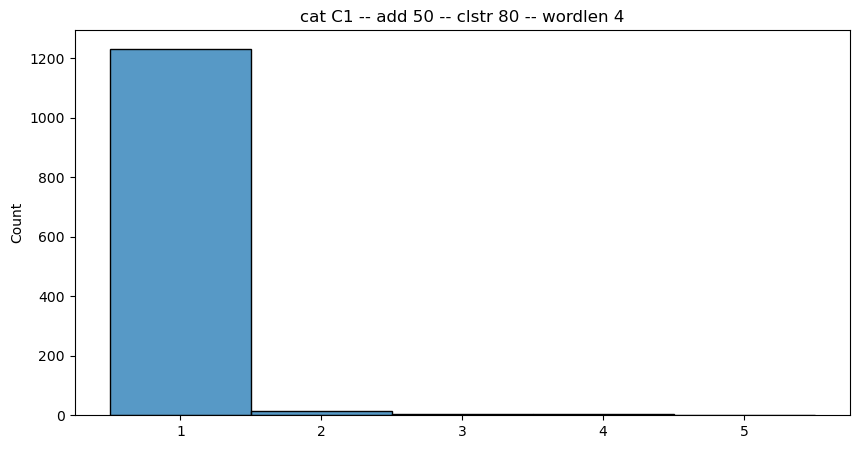

In [55]:
d = {}
buff = []
clstr_file = f'{os.getcwd()}/cd-hit-out/L2.clstr'
with open(clstr_file) as clstr:
    for i in clstr.readlines():
        a = i.rstrip()      
        if i.startswith(">"):
            d[a] = []
            buff.append(a)
        else:
            d[buff[-1]].append(a)

d_moreone = {}
for k, v in d.items():
    if len(v) > 1:
        d_moreone.update({k : v})

l_count = []
for k, v in d.items():
    l_count.append(len(v))
ax = sns.histplot(l_count, stat='count', discrete=True)
ax.bar_label(ax.containers[0])
plt.title("cat C1 -- add 50 -- clstr 80 -- wordlen 4") 

```cd-hit-est -i filt_fastas/C1.fasta -o C1_hits_1 -c 0.8 -n 4 -T 32 -M 40000 -g 1 -d 0 -t 0 -r 1 -sc 1 -b 40```

Text(0.5, 1.0, 'cat C1 -- add 50 -- clstr 80 -- wordlen 4 -- band 40')

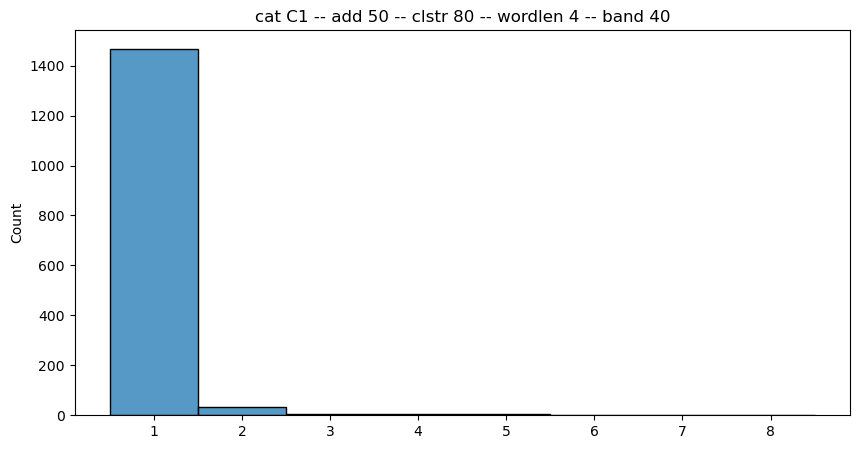

In [183]:
d = {}
buff = []
clstr_file = f'{os.getcwd()}/C1_hits_1.clstr'
with open(clstr_file) as clstr:
    for i in clstr.readlines():
        a = i.rstrip()      
        if i.startswith(">"):
            d[a] = []
            buff.append(a)
        else:
            d[buff[-1]].append(a)

d_moreone = {}
for k, v in d.items():
    if len(v) > 1:
        d_moreone.update({k : v})

l_count = []
for k, v in d.items():
    l_count.append(len(v))
ax = sns.histplot(l_count, stat='count', discrete=True)
ax.bar_label(ax.containers[0])
plt.title("cat C1 -- add 50 -- clstr 80 -- wordlen 4 -- band 40") 


In [4]:
print(matplotlib.__version__)

3.5.1


In [57]:
len(d_moreone)

25

In [58]:
for k, v in d_moreone.items():
    print(k)
    for i in v:
        print(i)

>Cluster 10
0	2559nt, >contig_53643:1189-3748... *
1	1955nt, >contig_55431:0-1955... at +/82.51%
>Cluster 38
0	2323nt, >contig_109879:7169-9492... *
1	2210nt, >contig_24057:30461-32671... at +/80.54%
2	2250nt, >contig_45179:44918-47168... at +/82.76%
3	970nt, >contig_65397:0-970... at -/82.78%
>Cluster 40
0	2276nt, >contig_100022:4676-6952... at -/80.67%
1	2311nt, >contig_119353:3411-5722... *
2	2289nt, >contig_9541:33068-35357... at +/80.21%
>Cluster 55
0	2249nt, >contig_111194:6101-8350... *
1	688nt, >contig_66197:0-688... at -/82.85%
>Cluster 65
0	2219nt, >contig_14781:66559-68778... at +/82.02%
1	2214nt, >contig_40247:11468-13682... at -/80.62%
2	2232nt, >contig_44909:11460-13692... *
3	672nt, >contig_96279:7268-7940... at -/80.65%
>Cluster 75
0	2201nt, >contig_12162:16033-18234... at -/85.10%
1	2209nt, >contig_1898:110668-112877... at -/82.39%
2	2213nt, >contig_3969:167472-169685... *
>Cluster 76
0	2212nt, >contig_5913:29065-31277... *
1	2206nt, >contig_77183:12986-15192... at -/9

In [71]:
!ls --color

C0_hits.clstr    C1_hits_50.clstr          dbcan3       test_ori.fasta
C1_hits          C1_hits_sorted.clstr      filt_fastas  test_res.fasta
C1_hits_1        anno                      filt_gffs
C1_hits_1.clstr  cd-hit-out                len_contigs
C1_hits_50       contig_28705:20734-22753  maft.fasta


In [75]:
!ls --color

C0_hits.clstr    C1_hits_50.clstr          dbcan3       test_ori.fasta
C1_hits          C1_hits_sorted.clstr      filt_fastas  test_res.fasta
C1_hits_1        anno                      filt_gffs
C1_hits_1.clstr  cd-hit-out                len_contigs
C1_hits_50       contig_28705:20734-22753  maft.fasta


In [128]:
with open('filt_gffs/') as into, open('') as outro:
for i in d_moreone['>Cluster 239']:
    m = re.search('nt\,\ (.+?)\.', i)
    if m:
        found = m.group(1)
        print(found)

IndentationError: expected an indented block (<ipython-input-128-60f2148a99f7>, line 2)

In [135]:
import re

x = {1: 2, 3: 4, 4: 3, 2: 1, 0: 0}
sorted_x = sorted(x.items(), key=lambda kv: kv[1])

In [157]:
for keys, values in d_moreone.items():
    print(keys , len(values))
        
# found = re.search('nt\,\ (.+?)\.', i).group(1)

>Cluster 10 2
>Cluster 38 4
>Cluster 40 3
>Cluster 55 2
>Cluster 65 4
>Cluster 75 3
>Cluster 76 2
>Cluster 77 2
>Cluster 79 2
>Cluster 107 2
>Cluster 111 2
>Cluster 124 2
>Cluster 125 2
>Cluster 126 2
>Cluster 200 2
>Cluster 212 3
>Cluster 217 3
>Cluster 221 4
>Cluster 225 2
>Cluster 239 5
>Cluster 243 3
>Cluster 449 2
>Cluster 482 2
>Cluster 669 2
>Cluster 1028 2


In [ ]:
!cat cd-hit-out/C1.clstr

In [187]:
dict(big_cluster)

{'>Cluster 0': ['0\t2019nt, >contig_28705:20734-22753... at +/85.54%',
  '1\t1342nt, >contig_28710:4051-5393... at -/87.41%',
  '2\t841nt, >contig_3374:24316-25157... at +/81.45%',
  '3\t2211nt, >contig_38893:6561-8772... at -/80.14%',
  '4\t2242nt, >contig_5404:62922-65164... *',
  '5\t2137nt, >contig_5430:4704-6841... at +/81.09%',
  '6\t2185nt, >contig_5433:608-2793... at -/81.05%',
  '7\t2191nt, >contig_5440:95968-98159... at -/80.37%'],
 '>Cluster 1': ['0\t2215nt, >contig_24789:20028-22243... at -/81.17%',
  '1\t2212nt, >contig_47348:11040-13252... at -/80.56%',
  '2\t2200nt, >contig_48098:56949-59149... at -/80.45%',
  '3\t2223nt, >contig_565:19491-21714... *',
  '4\t1446nt, >contig_73225:13274-14720... at -/80.22%',
  '5\t2174nt, >contig_9744:5217-7391... at +/82.11%'],
 '>Cluster 2': ['0\t1544nt, >contig_18949:1238-2782... at -/81.80%',
  '1\t1599nt, >contig_23657:4520-6119... *',
  '2\t1561nt, >contig_38447:27002-28563... at -/83.60%',
  '3\t1591nt, >contig_66769:803-2394... a

#### get top cluster, extract fastas from filt_fasta

In [209]:
records = SeqIO.parse(files_into[0], 'fasta')


AttributeError: 'FastaIterator' object has no attribute 'id'

In [282]:
!mafft --reorder --adjustdirection --auto catalases/cl_0.fasta > al_01.fasta


nthread = 0
nadd = 0
inputfile = infile
thresholdtorev = 0.000000
reflim = 5000
mode = a
generating a scoring matrix for nucleotide (dist=200) ... done

Step 1/2
1   

Step 2/2
 1 / 8   
makedirectionlist (nuc) Version 7.310 alg=m, model=DNA200 (2), 1.53 (4.59), 0.37 (1.11), noshift, amax=0.0
0 thread(s)

directionfile = _direction
inputfile = infile
subalignment = 0
subalignmentoffset = 0
8 x 2242 - 841 d
generating a scoring matrix for nucleotide (dist=200) ... done
All-to-all alignment.
tbfast-pair (nuc) Version 7.310 alg=L, model=DNA200 (2), 2.00 (6.00), -0.10 (-0.30), noshift, amax=0.0
0 thread(s)

Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00
treein = 0
compacttree = 0
Constructing a UPGMA tree ... 
    0 / 8
done.

Progressive alignment ... 
STEP     7 /7 c
done.
tbfast (nuc) Version 7.310 alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0


In [281]:
!ls catalases/

cl_0.fasta  cl_1.fasta	cl_2.fasta


In [276]:
big_cluster = sorted(d_moreone.items(), key=lambda x: len(x[1]), reverse=True)[:3]
big_cluster = dict(big_cluster)
for keys, values in big_cluster.items():
    with open(f'/mnt/storage/metagenome/rnf_c_new/catalases/cl_{keys.split(" ")[1]}.fasta', 'a') as result:
        for listed_result_for_cluster in values:
            m = re.search('nt\,\ (.+?)\.', listed_result_for_cluster)
            if m:
                found = m.group(1)
                print(found)
                records = SeqIO.parse(files_into[0], 'fasta')
    #             for record in (i for i in records if records.id in found):
                for record in records:
                    if record.id in found:
                        result.write(record.format('fasta'))
    #                     SeqIO.write(record, f'/mnt/storage/metagenome/rnf_c_new/test.fasta', 'fasta')                

>contig_28705:20734-22753
>contig_28710:4051-5393
>contig_3374:24316-25157
>contig_38893:6561-8772
>contig_5404:62922-65164
>contig_5430:4704-6841
>contig_5433:608-2793
>contig_5440:95968-98159
>contig_24789:20028-22243
>contig_47348:11040-13252
>contig_48098:56949-59149
>contig_565:19491-21714
>contig_73225:13274-14720
>contig_9744:5217-7391
>contig_18949:1238-2782
>contig_23657:4520-6119
>contig_38447:27002-28563
>contig_66769:803-2394
>contig_8213:23893-25486


In [296]:
!ls catalases/al

cl_0_al.fasta  cl_1_al.fasta  cl_2_al.fasta


In [295]:
%%bash

for file in catalases/*.fasta; do
    fname=$(basename "$file" .fasta)
#     mkdir catalases/al
    mafft --thread 20 --reorder --adjustdirection --auto $file > catalases/al/${fname}_al.fasta
done;


nthread = 20
nadd = 0
inputfile = infile
thresholdtorev = 0.000000
reflim = 5000
mode = a
generating a scoring matrix for nucleotide (dist=200) ... done

Step 1/2
1   

Step 2/2
 1 / 6 (20 threads)   
makedirectionlist (nuc) Version 7.310 alg=m, model=DNA200 (2), 1.53 (4.59), 0.37 (1.11), noshift, amax=0.0
20 thread(s)

directionfile = _direction
inputfile = infile
subalignment = 0
subalignmentoffset = 0
6 x 2242 - 2019 d
generating a scoring matrix for nucleotide (dist=200) ... done
All-to-all alignment.
tbfast-pair (nuc) Version 7.310 alg=L, model=DNA200 (2), 2.00 (6.00), -0.10 (-0.30), noshift, amax=0.0
20 thread(s)

Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00
treein = 0
compacttree = 0
Constructing a UPGMA tree ... 
    0 / 6
done.

Progressive alignment ... 
STEP     5 /5 (thread    4) c
done.
tbfast (nuc) Version 7.310 alg=A, model=DNA200 (2), 1.53 (4.59), -0

## Proceed project again

In [299]:
!ls --color

C0_hits.clstr          al_01_long.fasta          len_contigs
C1_hits                anno                      maft.fasta
C1_hits_1              cat_fastas                test
C1_hits_1.clstr        catalases                 test.fasta
C1_hits_50             cd-hit-out                test_cons_01.fasta
C1_hits_50.clstr       contig_28705:20734-22753  test_ori.fasta
C1_hits_sorted.clstr   dbcan3                    test_res.fasta
al_01.fasta            filt_fastas
al_01_long (copy).txt  filt_gffs


find another target fermentas from analysys

K00422 E1.10.3.1; polyphenol oxidase [EC:1.10.3.1]

In [302]:
keggRest("help")

['ENTRY', 'NAME', 'CLASS', 'SYSNAME', 'REACTION', 'ALL_REAC', 'SUBSTRATE', 'PRODUCT', 'COMMENT', 'HISTORY', 'REFERENCE', 'PATHWAY', 'ORTHOLOGY', 'GENES', 'DBLINKS']


In [301]:
keggRest("ko:K00422", ["NAME", "PATHWAY"])

NAME        polyphenol oxidase [EC:1.10.3.1]
PATHWAY     map00350  Tyrosine metabolism
            map00950  Isoquinoline alkaloid biosynthesis
            map01100  Metabolic pathways
            map01110  Biosynthesis of secondary metabolites


amazing fact 1: \
scaffolds only contain L1

In [310]:
df_polycat = df[df.KEGG_ko.str.contains("K00422", na=False)]

there is none alingnment here - select random from different sites

In [325]:
df_polycat.shape[0]

8

In [328]:
df_polycat.id

575212       C1_contig_39213_32
1680314     C2_contig_35473_134
2025939    C2_contig_55736_3825
2725122      C3_contig_19419_95
3494092       C3_contig_63_3260
5032204      L2_contig_42187_12
5198935      L2_contig_55836_29
6702087      L3_contig_64056_17
Name: id, dtype: object

In [332]:
df_gff

,seqid,source,type,start,end,score,strand,phase,attributes,site,id
0,contig_1,eggNOG-mapper,CDS,13,3014,1404.0,+,.,ID=contig_1_0;em_target=700598.Niako_5238;em_s...,C1,C1_contig_1_0
1,contig_1,eggNOG-mapper,CDS,3035,4732,790.0,+,.,ID=contig_1_3;em_target=700598.Niako_5237;em_s...,C1,C1_contig_1_3
2,contig_1,eggNOG-mapper,CDS,4764,6449,503.0,+,.,ID=contig_1_6;em_target=700598.Niako_5236;em_s...,C1,C1_contig_1_6
3,contig_1,eggNOG-mapper,CDS,6466,7868,623.0,+,.,ID=contig_1_5;em_target=700598.Niako_5235;em_s...,C1,C1_contig_1_5
4,contig_1,eggNOG-mapper,CDS,7937,8956,364.0,+,.,ID=contig_1_8;em_target=714943.Mucpa_2717;em_s...,C1,C1_contig_1_8
...,...,...,...,...,...,...,...,...,...,...,...
7243971,contig_99999,eggNOG-mapper,CDS,30008,31816,560.0,+,.,ID=contig_99999_2;em_target=234267.Acid_3577;e...,L3,L3_contig_99999_2
7243972,contig_99999,eggNOG-mapper,CDS,32783,33290,213.0,+,.,ID=contig_99999_12;em_target=1267535.KB906767_...,L3,L3_contig_99999_12
7243973,contig_99999,eggNOG-mapper,CDS,33355,34500,357.0,+,.,ID=contig_99999_5;em_target=1185876.BN8_01972;...,L3,L3_contig_99999_5
7243974,contig_99999,eggNOG-mapper,CDS,39194,40450,474.0,-,.,ID=contig_99999_3;em_target=1089547.KB913013_g...,L3,L3_contig_99999_3


#### peptidase

In [390]:
df.columns

Index(['#query', 'seed_ortholog', 'evalue', 'score', 'eggNOG_OGs',
       'max_annot_lvl', 'COG_category', 'Description', 'Preferred_name', 'GOs',
       'EC', 'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction',
       'KEGG_rclass', 'BRITE', 'KEGG_TC', 'CAZy', 'BiGG_Reaction', 'PFAMs',
       'site', 'id'],
      dtype='object')

In [ ]:
get = requests.get(f"https://rest.kegg.jp/get/br:ko01002")
text_get = get.text.split("\n")

proteases_kegg_list = []
for i in text_get:
    nice_match = re.search('C\s\s+(.*)\s\s+', i)
    if nice_match:
        res = nice_match.group(1)
        proteases_kegg_list.append(res)

proteases_query = "|".join(proteases_kegg_list)

In [ ]:
df_pep_ko = df[df.KEGG_ko.str.contains(proteases_query, na=False)]
query_pep_list = df_cat_ko["id"].to_list()

In [ ]:
add_split_conque(df_gff_l, query_pep_list, "pep", 100)

In [ ]:
%%bash

rm filt_fastas/*
mkdir peptidase
for file in ../rnf_c/fastas/*.fasta; do
    fname=$(basename "$file" .fasta)
    bedtools getfasta -fi $file -bed filt_gffs/${fname}_pep.gff > filt_fastas/${fname}.fasta
    cd-hit-est -i filt_fastas/${fname}.fasta -o cd-hit-out/${fname}_pep -c 0.8 -n 4 -T 32 -M 40000 -g 1 -d 0 -t 0 -r 1
done;


In [ ]:
fastas_from_clusters("peptidase", "pep")

In [ ]:
%%bash

mkdir peptidase/al
for file in peptidase/*.fasta; do
    fname=$(basename "$file" .fasta)  
    mafft --thread 20 --reorder --adjustdirection --auto $file > peptidase/al/${fname}_al.fasta
done;

Too long - try to use polars to this process

In [772]:
!ls --color

C0_hits.clstr          anno                      len_contigs
C1_hits                cat_fastas                len_contigs_old
C1_hits_1              catalases                 maft.fasta
C1_hits_1.clstr        cd-hit-out                peptidase
C1_hits_50             contig_28705:20734-22753  test
C1_hits_50.clstr       dbcan3                    test.fasta
C1_hits_sorted.clstr   df                        test_cons_01.fasta
al_01.fasta            df_gff_l                  test_ori.fasta
al_01_long (copy).txt  filt_fastas               test_res.fasta
al_01_long.fasta       filt_gffs


In [559]:
!ls peptidase/

C0_hits.clstr	       anno			 len_contigs
C1_hits		       cat_fastas		 maft.fasta
C1_hits_1	       catalases		 peptidase
C1_hits_1.clstr        cd-hit-out		 test
C1_hits_50	       contig_28705:20734-22753  test.fasta
C1_hits_50.clstr       dbcan3			 test_cons_01.fasta
C1_hits_sorted.clstr   df			 test_ori.fasta
al_01.fasta	       df_gff_l			 test_res.fasta
al_01_long (copy).txt  filt_fastas
al_01_long.fasta       filt_gffs


#### catalase last steps 

In [732]:
cat_list = ["K03781", "K19885"]
cat_query = "|".join(cat_list)

df_cat_ko = df[df.KEGG_ko.str.contains(cat_query, na=False)]
query_cat_list = df_cat_ko["id"].to_list()

In [661]:
%mkdir test

In [695]:
df_gff_test = df_gff_l.loc[df_gff_l['site'].isin(['C2']) ]

In [ ]:
add_split_conque(df_gff_l, query_cat_list, "cat", 100)
# !bedtools getfasta -fi ../rnf_c/fastas/C2.fasta -bed test/C2_test.gff > test/C2_fas.fasta

In [742]:
!ls filt_gffs/

C1_pep.gff  C2_test.gff  L1_pep.gff  L3_pep.gff
C2_pep.gff  C3_pep.gff	 L2_pep.gff


In [748]:
%%bash

rm filt_fastas/*
rm cd-hit-out/*_cat.clstr
rm filt_gffs/*_cat.gff

In [746]:
!ls filt_gffs/

C1_pep.gff  C2_pep.gff	 C3_pep.gff  L2_pep.gff
C2_cat.gff  C2_test.gff  L1_pep.gff  L3_pep.gff


In [ ]:
%%bash

for file in ../rnf_c/fastas/*.fasta; do
    fname=$(basename "$file" .fasta)
    bedtools getfasta -fi $file -bed filt_gffs/${fname}_cat.gff > filt_fastas/${fname}.fasta
    cd-hit-est -i filt_fastas/${fname}.fasta -o cd-hit-out/${fname}_cat -c 0.8 -n 4 -T 32 -M 40000 -g 1 -d 0 -t 0 -r 1
done;


In [694]:
!ls -ahts test

total 5.0M
1.8M L3.fasta  1.6M L2.fasta  248K L3_test.gff	156K L1_test.gff
4.0K .	       1.1M L1.fasta  228K L2_test.gff	4.0K ..


In [ ]:
df_gff_l.loc[(df_gff_l.seqid.isin(["contig_20799", "contig_20799", "contig_24852", "contig_25202"])) & (df_gff_l.site == 'C2')]

In [702]:
header = ["seqid", "source", "type", "start", "end", "score", "strand", "phase", "attributes"]
df_t = pd.read_csv('test/C2_test.gff', sep="\t", names=header, header=None, index_col=False)
# df_t.loc[df_t.seqid =="contig_15726"]
# sns.histplot(df_t["Length"], bins=100)

In [766]:
fastas_from_clusters("catalases", "cat")

In [712]:
df_t.loc[df_t.seqid.isin(["contig_20799", "contig_20799", "contig_24852", "contig_25202"])]

,seqid,source,type,start,end,score,strand,phase,attributes
214,contig_20799,eggNOG-mapper,CDS,24394,26683,972.0,-,.,ID=contig_20799_0;em_target=62928.azo3768;em_s...
282,contig_24852,eggNOG-mapper,CDS,1989,2582,173.0,+,.,ID=contig_24852_1;em_target=1462527.CCDM010000...
286,contig_25202,eggNOG-mapper,CDS,4194,5859,932.0,+,.,ID=contig_25202_1;em_target=670292.JH26_18685;...
287,contig_25202,eggNOG-mapper,CDS,5909,6757,407.0,-,.,ID=contig_25202_12;em_target=864069.MicloDRAFT...
288,contig_25202,eggNOG-mapper,CDS,10899,11901,458.0,-,.,ID=contig_25202_10;em_target=420324.KI911955_g...
289,contig_25202,eggNOG-mapper,CDS,14209,14899,90.9,-,.,ID=contig_25202_18;em_target=73044.JNXP0100002...
290,contig_25202,eggNOG-mapper,CDS,14912,15600,110.0,-,.,ID=contig_25202_15;em_target=1381123.AYOD01000...
291,contig_25202,eggNOG-mapper,CDS,16177,17450,413.0,+,.,ID=contig_25202_13;em_target=663610.JQKO010000...
292,contig_25202,eggNOG-mapper,CDS,18270,19048,307.0,+,.,ID=contig_25202_17;em_target=420324.KI911955_g...
293,contig_25202,eggNOG-mapper,CDS,19108,19888,305.0,-,.,ID=contig_25202_19;em_target=420324.KI912039_g...


In [ ]:
%%bash

mkdir catalases/al
for file in catalases/*.fasta; do
    fname=$(basename "$file" .fasta)  
    mafft --thread 20 --reorder --adjustdirection --auto $file > catalases/al/${fname}_al.fasta
done;

In [769]:
!grep -c ">" catalases/al/*

catalases/al/cat_C1_234_al.fasta:5
catalases/al/cat_C1_59_al.fasta:5
catalases/al/cat_C1_60_al.fasta:5
catalases/al/cat_C2_248_al.fasta:4
catalases/al/cat_C2_61_al.fasta:3
catalases/al/cat_C2_84_al.fasta:3
catalases/al/cat_C3_16_al.fasta:2
catalases/al/cat_C3_198_al.fasta:4
catalases/al/cat_C3_206_al.fasta:3
catalases/al/cat_L1_113_al.fasta:8
catalases/al/cat_L1_19_al.fasta:3
catalases/al/cat_L1_43_al.fasta:3
catalases/al/cat_L2_224_al.fasta:4
catalases/al/cat_L2_38_al.fasta:3
catalases/al/cat_L2_76_al.fasta:3
catalases/al/cat_L3_241_al.fasta:5
catalases/al/cat_L3_87_al.fasta:4
catalases/al/cat_L3_91_al.fasta:3


### endocellulases

In [774]:
df

,#query,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,EC,KEGG_ko,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs,site,id
0,contig_1_0,700598.Niako_5238,0.000000e+00,1404.0,"COG1629@1|root,COG1629@2|Bacteria,4NDXS@976|Ba...",976|Bacteroidetes,P,CarboxypepD_reg-like domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"CarbopepD_reg_2,Plug,TonB_dep_Rec",C1,C1_contig_1_0
1,contig_1_3,700598.Niako_5237,4.340000e-255,790.0,"COG1435@1|root,COG1435@2|Bacteria,4NHCM@976|Ba...",976|Bacteroidetes,F,SusD family,NaN,NaN,NaN,ko:K21572,NaN,NaN,NaN,NaN,"ko00000,ko02000","8.A.46.1,8.A.46.3",NaN,NaN,"SusD-like_3,SusD_RagB",C1,C1_contig_1_3
2,contig_1_6,700598.Niako_5236,3.420000e-155,503.0,"28IBC@1|root,2Z8DV@2|Bacteria,4NQRQ@976|Bacter...",976|Bacteroidetes,S,Domain of unknown function (DUF5018),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DUF5018,C1,C1_contig_1_6
3,contig_1_5,700598.Niako_5235,2.440000e-198,623.0,"COG1649@1|root,COG1649@2|Bacteria,4PHU5@976|Ba...",976|Bacteroidetes,S,Domain of unknown function,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"DUF4985,GHL10",C1,C1_contig_1_5
4,contig_1_8,714943.Mucpa_2717,3.390000e-110,364.0,"COG4632@1|root,COG4632@2|Bacteria,4NR1M@976|Ba...",976|Bacteroidetes,G,COGs COG4632 Exopolysaccharide biosynthesis pr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Metallophos,NAGPA,fn3",C1,C1_contig_1_8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7243952,contig_99999_2,234267.Acid_3577,8.550000e-174,560.0,"COG0249@1|root,COG0249@2|Bacteria,3Y48T@57723|...",57723|Acidobacteria,L,ATPase domain of DNA mismatch repair MUTS family,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MutS_III,MutS_V",L3,L3_contig_99999_2
7243953,contig_99999_12,1267535.KB906767_gene5280,1.090000e-59,213.0,"COG1329@1|root,COG1329@2|Bacteria,3Y4ZG@57723|...",204432|Acidobacteriia,K,CarD-like/TRCF domain,NaN,NaN,NaN,ko:K07736,NaN,NaN,NaN,NaN,"ko00000,ko03000",NaN,NaN,NaN,CarD_CdnL_TRCF,L3,L3_contig_99999_12
7243954,contig_99999_5,1185876.BN8_01972,3.150000e-106,357.0,"COG4948@1|root,COG4948@2|Bacteria,4NGZF@976|Ba...",976|Bacteroidetes,M,mandelate racemase muconate lactonizing,NaN,NaN,4.2.1.68,ko:K18334,"ko00051,ko01120,map00051,map01120",NaN,R03688,RC00543,"ko00000,ko00001,ko01000",NaN,NaN,NaN,"MR_MLE_C,MR_MLE_N",L3,L3_contig_99999_5
7243955,contig_99999_3,1089547.KB913013_gene1278,4.130000e-147,474.0,"COG3458@1|root,COG3458@2|Bacteria,4NGH5@976|Ba...",976|Bacteroidetes,Q,PFAM Acetyl xylan esterase,axe7A_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AXE1,L3,L3_contig_99999_3


EC.3.2.1.4 - endocellulases, based on https://doi.org/10.1007%2Fs00253-018-8778-y

In [776]:
keggRest("3.2.1.4")

ORTHOLOGY   K01179  endoglucanase
            K19357  cellulase
            K20542  endoglucanase


In [815]:
endonuclease_query = "|".join(['K01179', 'K20542'])
df_endo_ko = df[df.KEGG_ko.str.contains(endonuclease_query, na=False)]
query_endo_list = df_endo_ko["id"].to_list()

In [816]:
add_split_conque(df_gff_l, query_endo_list, "endo", 100)

                seqid         source type    start      end  score strand  \
823      contig_10014  eggNOG-mapper  CDS   596343   597419  724.0      -   
4832     contig_10116  eggNOG-mapper  CDS     6888     7346   59.7      -   
5861     contig_10117  eggNOG-mapper  CDS  1302653  1303447   86.7      -   
7638     contig_10147  eggNOG-mapper  CDS     2158     3391  519.0      +   
13428    contig_10348  eggNOG-mapper  CDS    44777    46438  789.0      +   
...               ...            ...  ...      ...      ...    ...    ...   
7239810   contig_9978  eggNOG-mapper  CDS   661182   662526  347.0      +   
7239824   contig_9978  eggNOG-mapper  CDS   674129   675220  357.0      -   
7240914  contig_99845  eggNOG-mapper  CDS     2393     3253  282.0      +   
7241610  contig_99883  eggNOG-mapper  CDS     6214     6690  181.0      -   
7242404  contig_99923  eggNOG-mapper  CDS     7471     8058   75.5      -   

        phase                                         attributes site  \
82

<ipython-input-747-91a48a36a3a7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gff_cat_ch['start'] = df_gff_cat_ch['start'] - add_number
<ipython-input-747-91a48a36a3a7>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gff_cat_ch['end'] = df_gff_cat_ch['end'] + add_number


In [ ]:
%%bash

rm filt_fastas/*
prefix=endo
for file in ../rnf_c/fastas/*.fasta; do
    fname=$(basename "$file" .fasta)
    bedtools getfasta -fi $file -bed filt_gffs/${fname}_${prefix}.gff > filt_fastas/${fname}.fasta
    cd-hit-est -i filt_fastas/${fname}.fasta -o cd-hit-out/${fname}_${prefix} -c 0.8 -n 4 -T 32 -M 40000 -g 1 -d 0 -t 0 -r 1
done;
mkdir endo

Program: CD-HIT, V4.8.1 (+OpenMP), Apr 07 2021, 10:57:21
Command: cd-hit-est -i filt_fastas/C1.fasta -o
         cd-hit-out/C1_endo -c 0.8 -n 4 -T 32 -M 40000 -g 1 -d
         0 -t 0 -r 1

Started: Wed Oct 26 19:29:58 2022
                            Output                              
----------------------------------------------------------------
total seq: 1742
longest and shortest : 12040 and 258
Total letters: 2175983
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 2M
Buffer          : 32 X 14M = 468M
Table           : 2 X 0M = 0M
Miscellaneous   : 0M
Total           : 470M

Table limit with the given memory limit:
Max number of representatives: 4000000
Max number of word counting entries: 4941178711

# comparing sequences from          0  to         51
---------- new table with       49 representatives
# comparing sequences from         51  to        100
98.6%---------- new table with       46 representatives
# comparing sequences from    

In [ ]:
fastas_from_clusters("endo", "endo")

In [ ]:
%%bash

mkdir catalases/al
prefix=endo
directory=endo
for file in ${directory}/*.fasta; do
    fname=$(basename "$file" .fasta)  
    mafft --thread 20 --reorder --adjustdirection --auto $file > ${directory}/al/${fname}_{$prefix}.fasta
done;

### exocellulases

In [774]:
df

,#query,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,EC,KEGG_ko,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs,site,id
0,contig_1_0,700598.Niako_5238,0.000000e+00,1404.0,"COG1629@1|root,COG1629@2|Bacteria,4NDXS@976|Ba...",976|Bacteroidetes,P,CarboxypepD_reg-like domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"CarbopepD_reg_2,Plug,TonB_dep_Rec",C1,C1_contig_1_0
1,contig_1_3,700598.Niako_5237,4.340000e-255,790.0,"COG1435@1|root,COG1435@2|Bacteria,4NHCM@976|Ba...",976|Bacteroidetes,F,SusD family,NaN,NaN,NaN,ko:K21572,NaN,NaN,NaN,NaN,"ko00000,ko02000","8.A.46.1,8.A.46.3",NaN,NaN,"SusD-like_3,SusD_RagB",C1,C1_contig_1_3
2,contig_1_6,700598.Niako_5236,3.420000e-155,503.0,"28IBC@1|root,2Z8DV@2|Bacteria,4NQRQ@976|Bacter...",976|Bacteroidetes,S,Domain of unknown function (DUF5018),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DUF5018,C1,C1_contig_1_6
3,contig_1_5,700598.Niako_5235,2.440000e-198,623.0,"COG1649@1|root,COG1649@2|Bacteria,4PHU5@976|Ba...",976|Bacteroidetes,S,Domain of unknown function,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"DUF4985,GHL10",C1,C1_contig_1_5
4,contig_1_8,714943.Mucpa_2717,3.390000e-110,364.0,"COG4632@1|root,COG4632@2|Bacteria,4NR1M@976|Ba...",976|Bacteroidetes,G,COGs COG4632 Exopolysaccharide biosynthesis pr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Metallophos,NAGPA,fn3",C1,C1_contig_1_8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7243952,contig_99999_2,234267.Acid_3577,8.550000e-174,560.0,"COG0249@1|root,COG0249@2|Bacteria,3Y48T@57723|...",57723|Acidobacteria,L,ATPase domain of DNA mismatch repair MUTS family,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MutS_III,MutS_V",L3,L3_contig_99999_2
7243953,contig_99999_12,1267535.KB906767_gene5280,1.090000e-59,213.0,"COG1329@1|root,COG1329@2|Bacteria,3Y4ZG@57723|...",204432|Acidobacteriia,K,CarD-like/TRCF domain,NaN,NaN,NaN,ko:K07736,NaN,NaN,NaN,NaN,"ko00000,ko03000",NaN,NaN,NaN,CarD_CdnL_TRCF,L3,L3_contig_99999_12
7243954,contig_99999_5,1185876.BN8_01972,3.150000e-106,357.0,"COG4948@1|root,COG4948@2|Bacteria,4NGZF@976|Ba...",976|Bacteroidetes,M,mandelate racemase muconate lactonizing,NaN,NaN,4.2.1.68,ko:K18334,"ko00051,ko01120,map00051,map01120",NaN,R03688,RC00543,"ko00000,ko00001,ko01000",NaN,NaN,NaN,"MR_MLE_C,MR_MLE_N",L3,L3_contig_99999_5
7243955,contig_99999_3,1089547.KB913013_gene1278,4.130000e-147,474.0,"COG3458@1|root,COG3458@2|Bacteria,4NGH5@976|Ba...",976|Bacteroidetes,Q,PFAM Acetyl xylan esterase,axe7A_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AXE1,L3,L3_contig_99999_3


EC.3.2.1.21 - exocellulases, based on https://doi.org/10.1007%2Fs00253-018-8778-y

In [795]:
keggRest("3.2.1.21", ["ORTHOLOGY", "NAME"])

NAME        beta-glucosidase;
            gentiobiase;
            cellobiase;
            emulsin;
            elaterase;
            aryl-beta-glucosidase;
            beta-D-glucosidase;
            beta-glucoside glucohydrolase;
            arbutinase;
            amygdalinase;
            p-nitrophenyl beta-glucosidase;
            primeverosidase;
            amygdalase;
            linamarase;
            salicilinase;
            beta-1,6-glucosidase
ORTHOLOGY   K01188  beta-glucosidase
            K05349  beta-glucosidase
            K05350  beta-glucosidase


In [799]:
keggRest("3.2.1.74", ["NAME", "ORTOLOGY","PATHWAY"])

NAME        glucan 1,4-beta-glucosidase;
            exo-1,4-beta-glucosidase;
            exocellulase;
            exo-beta-1,4-glucosidase;
            exo-beta-1,4-glucanase;
            beta-1,4-beta-glucanase;
            beta-glucosidase;
            exo-1,4-beta-glucanase;
            1,4-beta-D-glucan glucohydrolase
PATHWAY     ec00500  Starch and sucrose metabolism
            ec01100  Metabolic pathways


In [792]:
keggRest("help")

['ENTRY', 'NAME', 'CLASS', 'SYSNAME', 'REACTION', 'ALL_REAC', 'SUBSTRATE', 'PRODUCT', 'COMMENT', 'HISTORY', 'REFERENCE', 'PATHWAY', 'ORTHOLOGY', 'GENES', 'DBLINKS']


In [ ]:
exocellulase_query = "|".join(['K01188', 'K05349', 'K05350'])
df_exo_ko = df[df.KEGG_ko.str.contains(exocellulase_query, na=False)]
query_exo_list = df_exo_ko["id"].to_list()

In [ ]:
add_split_conque(df_gff_l, query_exo_list, "endo", 100)

In [ ]:
%%bash

prefix=exo
rm filt_fastas/*
for file in ../rnf_c/fastas/*.fasta; do
    fname=$(basename "$file" .fasta)
    bedtools getfasta -fi $file -bed filt_gffs/${fname}_${prefix}.gff > filt_fastas/${fname}.fasta
    cd-hit-est -i filt_fastas/${fname}.fasta -o cd-hit-out/${fname}_${prefix} -c 0.8 -n 4 -T 32 -M 40000 -g 1 -d 0 -t 0 -r 1
done;
mkdir exo

In [ ]:
fastas_from_clusters("exo", "exo")

In [ ]:
%%bash

mkdir exo/al
prefix=exo
directory=exo
for file in ${directory}/*.fasta; do
    fname=$(basename "$file" .fasta)  
    mafft --thread 20 --reorder --adjustdirection --auto $file > ${directory}/al/${fname}_{$prefix}.fasta
done;

### amylase

EC.3.2.1.1 - amylase, based on wiki

In [801]:
keggRest("3.2.1.1", ["ORTHOLOGY", "NAME"])

NAME        alpha-amylase;
            glycogenase;
            alpha amylase;
            endoamylase;
            Taka-amylase A;
            1,4-alpha-D-glucan glucanohydrolase
ORTHOLOGY   K01176  alpha-amylase
            K05343  maltose alpha-D-glucosyltransferase / alpha-amylase
            K07405  alpha-amylase


In [ ]:
amylase_query = "|".join(['K01176', 'K05343', 'K07405'])
df_amy_ko = df[df.KEGG_ko.str.contains(amylase_query, na=False)]
query_amy_list = df_amy_ko["id"].to_list()

In [ ]:
add_split_conque(df_gff_l, query_amy_list, "amy", 100)

In [ ]:
%%bash

prefix=amy
for file in ../rnf_c/fastas/*.fasta; do
    fname=$(basename "$file" .fasta)
    bedtools getfasta -fi $file -bed filt_gffs/${fname}_${prefix}.gff > filt_fastas/${fname}.fasta
    cd-hit-est -i filt_fastas/${fname}.fasta -o cd-hit-out/${fname}_${prefix} -c 0.8 -n 4 -T 32 -M 40000 -g 1 -d 0 -t 0 -r 1
done;
mkdir amylases

In [ ]:
fastas_from_clusters("amylases", "amy")

In [ ]:
%%bash

mkdir amylases/al
prefix=amy
directory=amylases
for file in ${directory}/*.fasta; do
    fname=$(basename "$file" .fasta)  
    mafft --thread 20 --reorder --adjustdirection --auto $file > ${directory}/al/${fname}_{$prefix}.fasta
done;

### invertases

EC.3.2.1.26 - invertase, based on wiki

In [802]:
keggRest("3.2.1.26", ["ORTHOLOGY", "NAME"])

NAME        beta-fructofuranosidase;
            invertase;
            saccharase;
            glucosucrase;
            beta-h-fructosidase;
            beta-fructosidase;
            invertin;
            sucrase;
            maxinvert L 1000;
            fructosylinvertase;
            alkaline invertase;
            acid invertase
ORTHOLOGY   K01193  beta-fructofuranosidase


In [ ]:
# exocellulase_query = "|".join(['K01188', 'K05349', 'K05350'])
df_inv_ko = df[df.KEGG_ko.str.contains("K01193", na=False)]
query_inv_list = df_inv_ko["id"].to_list()

In [ ]:
add_split_conque(df_gff_l, query_inv_list, "inv", 100)

In [ ]:
%%bash

prefix=inv
rm filt_fastas/*
for file in ../rnf_c/fastas/*.fasta; do
    fname=$(basename "$file" .fasta)
    bedtools getfasta -fi $file -bed filt_gffs/${fname}_${prefix}.gff > filt_fastas/${fname}.fasta
    cd-hit-est -i filt_fastas/${fname}.fasta -o cd-hit-out/${fname}_${prefix} -c 0.8 -n 4 -T 32 -M 40000 -g 1 -d 0 -t 0 -r 1
done;
mkdir invertases

In [ ]:
fastas_from_clusters("invertases", "inv")

In [ ]:
%%bash

mkdir exo/al
prefix=inv
directory=invertases
for file in ${directory}/*.fasta; do
    fname=$(basename "$file" .fasta)  
    mafft --thread 20 --reorder --adjustdirection --auto $file > ${directory}/al/${fname}_{$prefix}.fasta
done;

### polyphenoloxidase 

K00422 E1.10.3.1; polyphenol oxidase [EC:1.10.3.1]

In [ ]:
# exocellulase_query = "|".join(['K01188', 'K05349', 'K05350'])
df_poly_ko = df[df.KEGG_ko.str.contains("K00422", na=False)]
query_poly_list = df_poly_ko["id"].to_list()

In [ ]:
add_split_conque(df_gff_l, query_poly_list, "poly", 100)

In [ ]:
%%bash

prefix=poly
rm filt_fastas/*
for file in ../rnf_c/fastas/*.fasta; do
    fname=$(basename "$file" .fasta)
    bedtools getfasta -fi $file -bed filt_gffs/${fname}_${prefix}.gff > filt_fastas/${fname}.fasta
    cd-hit-est -i filt_fastas/${fname}.fasta -o cd-hit-out/${fname}_${prefix} -c 0.8 -n 4 -T 32 -M 40000 -g 1 -d 0 -t 0 -r 1
done;
mkdir polyphenoloxidases

In [ ]:
fastas_from_clusters("polyphenoloxidases", "poly")

In [ ]:
%%bash

mkdir exo/al
prefix=poly
directory=polyphenoloxidases
for file in ${directory}/*.fasta; do
    fname=$(basename "$file" .fasta)  
    mafft --thread 20 --reorder --adjustdirection --auto $file > ${directory}/al/${fname}_{$prefix}.fasta
done;

### peroxidases

In [808]:
for i in [i for i in range(1, 30)]:
    keggRest(f"1.11.1.{i}")

ORTHOLOGY   K05910  NADH peroxidase
ORTHOLOGY   K00428  cytochrome c peroxidase
ORTHOLOGY   K03781  catalase
            K19885  dichlorochromopyrrolate synthase / catalase
ORTHOLOGY   K00430  peroxidase
            K10788  eosinophil peroxidase
            K11188  peroxiredoxin 6
            K12550  lactoperoxidase
            K19511  peroxidase
            K21201  cytochrome P450 family 119
ORTHOLOGY   K00431  thyroid peroxidase
ORTHOLOGY   K00432  glutathione peroxidase
ORTHOLOGY   K00433  non-heme chloroperoxidase
            K17990  vanadium chloroperoxidase
ORTHOLOGY   K00434  L-ascorbate peroxidase
ORTHOLOGY   K05361  phospholipid-hydroperoxide glutathione peroxidase
ORTHOLOGY   K20205  manganese peroxidase
ORTHOLOGY   K23515  lignin peroxidase
ORTHOLOGY   K23075  glutathione amide-dependent peroxidase
ORTHOLOGY   K20206  bromide peroxidase
ORTHOLOGY   K15733  dye decolorizing peroxidase
ORTHOLOGY   K15717  prostamide/prostaglandin F2alpha synthase
ORTHOLOGY   K03782  catalase-p

add txt file pero from the export above

In [ ]:
pero_kegg_list = []
with open('pero') as pero:
    for i in pero.readlines():
        pero_kegg_list.append(i.lstrip().rstrip())
pero_query = "|".join(pero_kegg_list)
df_pero_ko = df[df.KEGG_ko.str.contains(pero_query, na=False)]
query_pero_list = df_pero_ko["id"].to_list()

In [ ]:
add_split_conque(df_gff_l, query_pero_list, "pero", 100)

In [ ]:
%%bash

prefix=pero
rm filt_fastas/*
for file in ../rnf_c/fastas/*.fasta; do
    fname=$(basename "$file" .fasta)
    bedtools getfasta -fi $file -bed filt_gffs/${fname}_${prefix}.gff > filt_fastas/${fname}.fasta
    cd-hit-est -i filt_fastas/${fname}.fasta -o cd-hit-out/${fname}_${prefix} -c 0.8 -n 4 -T 32 -M 40000 -g 1 -d 0 -t 0 -r 1
done;
mkdir peroxidases

In [ ]:
fastas_from_clusters("peroxidases", "pero")

In [ ]:
%%bash

mkdir peroxidases/al
prefix=pero
directory=peroxidases
for file in ${directory}/*.fasta; do
    fname=$(basename "$file" .fasta)  
    mafft --thread 20 --reorder --adjustdirection --auto $file > ${directory}/al/${fname}_{$prefix}.fasta
done;

# Test

In [479]:
import polars as pl
import pyarrow as pa

In [474]:
with open("df_gff_l", "wb") as fp:
    pickle.dump(df_gff_l, fp)
with open("df", "wb") as fp:
    pickle.dump(df, fp)

In [486]:
df_gff_l

,seqid,source,type,start,end,score,strand,phase,attributes,site,id,contig_len
0,contig_1,eggNOG-mapper,CDS,13,3014,1404.0,+,.,ID=contig_1_0;em_target=700598.Niako_5238;em_s...,C1,C1_contig_1_0,18772.0
1,contig_1,eggNOG-mapper,CDS,3035,4732,790.0,+,.,ID=contig_1_3;em_target=700598.Niako_5237;em_s...,C1,C1_contig_1_3,18772.0
2,contig_1,eggNOG-mapper,CDS,4764,6449,503.0,+,.,ID=contig_1_6;em_target=700598.Niako_5236;em_s...,C1,C1_contig_1_6,18772.0
3,contig_1,eggNOG-mapper,CDS,6466,7868,623.0,+,.,ID=contig_1_5;em_target=700598.Niako_5235;em_s...,C1,C1_contig_1_5,18772.0
4,contig_1,eggNOG-mapper,CDS,7937,8956,364.0,+,.,ID=contig_1_8;em_target=714943.Mucpa_2717;em_s...,C1,C1_contig_1_8,18772.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7243971,contig_99999,eggNOG-mapper,CDS,30008,31816,560.0,+,.,ID=contig_99999_2;em_target=234267.Acid_3577;e...,L3,L3_contig_99999_2,42177.0
7243972,contig_99999,eggNOG-mapper,CDS,32783,33290,213.0,+,.,ID=contig_99999_12;em_target=1267535.KB906767_...,L3,L3_contig_99999_12,42177.0
7243973,contig_99999,eggNOG-mapper,CDS,33355,34500,357.0,+,.,ID=contig_99999_5;em_target=1185876.BN8_01972;...,L3,L3_contig_99999_5,42177.0
7243974,contig_99999,eggNOG-mapper,CDS,39194,40450,474.0,-,.,ID=contig_99999_3;em_target=1089547.KB913013_g...,L3,L3_contig_99999_3,42177.0


In [481]:
pad_gff_l = pa.Table.from_pandas(df_gff_l) 

In [487]:
pl_gff_l = pl.from_pandas(df_gff_l)

ImportError: 'pyarrow' is required when using from_arrow().

In [155]:
!grep ">" anno/C1.emapper.genepred.fasta | tail -n 10

>contig_9997_11
>contig_9997_18
>contig_9997_15
>contig_9997_8
>contig_9997_12
>contig_9997_2
>contig_9997_4
>contig_9997_10
>contig_9997_7
>contig_9999_0


In [ ]:
df_cat_ko = df[df.KEGG_ko.str.contains("K03781|K19885", na=False)]

In [193]:
files_into = sorted(glob.glob(f"{os.getcwd()}/filt_fastas/*"))
files_into

['/mnt/storage/metagenome/rnf_c_new/filt_fastas/C1.fasta',
 '/mnt/storage/metagenome/rnf_c_new/filt_fastas/C2.fasta',
 '/mnt/storage/metagenome/rnf_c_new/filt_fastas/C3.fasta',
 '/mnt/storage/metagenome/rnf_c_new/filt_fastas/L1.fasta',
 '/mnt/storage/metagenome/rnf_c_new/filt_fastas/L2.fasta',
 '/mnt/storage/metagenome/rnf_c_new/filt_fastas/L3.fasta']

In [23]:
%%bash

for file in ../rnf_c/fastas/*.fasta; do
    fname=$(basename "$file" .fasta)
    echo filt_gffs/${fname}_cat.gff
    ls filt_gffs | grep $fname
done;


filt_gffs/C1_cat.gff
C1_cat.gff
filt_gffs/C2_cat.gff
C2_cat.gff
filt_gffs/C3_cat.gff
C3_cat.gff
filt_gffs/L1_cat.gff
L1_cat.gff
filt_gffs/L2_cat.gff
L2_cat.gff
filt_gffs/L3_cat.gff
L3_cat.gff


In [100]:
with open(files_into[1], 'r') as f:
    print([i for i in f])

[]


In [101]:
files_into[0]

'/mnt/storage/metagenome/rnf_c_new/filt_fastas/C1.fasta'

In [122]:
for record in SeqIO.parse(files_into[0], 'fasta'):
    print()
    g

NameError: name 'g' is not defined

In [1]:
keggRest()

454.Cd.R		 domain_analysis.ipynb
Al			 eggnog_R.ipynb
Al.R			 elize_delete.py
Al.Rmd			 endo.Rmd
Al.html			 fire_end.R
Al.ipynb		 freqsigch.py
Al.wgc.txt		 functions.R
Al_RF_2-Copy1.ipynb	 gh_contig_hist.ipynb
Al_RF_2.ipynb		 git.sh
Al_rf_fregression.ipynb  glyc.Rmd
Al_s2_version.Rmd	 heat_graphs.R
AnDan.Rmd		 hmmer.ipynb
CRT.R			 hmms.ipynb
CRT_Functions_v1.1.R	 idtaxa.Rmd
Des.Sim.Otu.Phylo.R	 iqtee_chi_al_d_2.tsv
Deseq2_adundanse.R	 kate_cca.R
Krio_1.ipynb		 kate_cca.txt
MC_rf_and_plots.ipynb	 kim_plot.R
PandasHW.ipynb		 krak_galega.ipynb
R.ipynb			 krim_chrono.R
README.md		 kuz.Rmd
RefSeq.ipynb		 lazy_kuz.R
StepicPython.ipynb	 ligninase.ipynb
Untitled.ipynb		 linear.ipynb
Untitled1.ipynb		 lise.heat.R
Untitled2.ipynb		 lize_shitty_prop_delete.R
Untitled3.ipynb		 main.sh
Untitled4.ipynb		 mal_2021.Rmd
Untitled5.ipynb		 mantel.R
Untitled6.ipynb		 metabat2.sh
Untitled7.ipynb		 nadim_pipe.R
Untitled8.ipynb		 nadim_pipe.Rmd
Wine_trees.ipynb	 nal.Rmd
align.ipynb		 nal_clean.Rmd
align_.ipy

In [ ]:
with open(original_file) as original, open(corrected_file, 'w') as corrected:
    records = SeqIO.parse(original_file, 'fasta')
    for record in enumerate(records):
        record[1].id = f'contig_{record[0]}'
        record[1].description = f'contig_{record[0]}'
        SeqIO.write(record[1], corrected, 'fasta' )

In [284]:
!ls

C0_hits.clstr	      anno			len_contigs
C1_hits		      cat_fastas		maft.fasta
C1_hits_1	      catalases			test
C1_hits_1.clstr       cd-hit-out		test.fasta
C1_hits_50	      contig_28705:20734-22753	test_ori.fasta
C1_hits_50.clstr      dbcan3			test_res.fasta
C1_hits_sorted.clstr  filt_fastas
al_01.fasta	      filt_gffs


In [ ]:
!mafft --thread 20 --reorder --adjustdirection --auto input

In [287]:
!ls --color

C0_hits.clstr         al_01_long (copy).txt     filt_fastas
C1_hits               al_01_long.fasta          filt_gffs
C1_hits_1             anno                      len_contigs
C1_hits_1.clstr       cat_fastas                maft.fasta
C1_hits_50            catalases                 test
C1_hits_50.clstr      cd-hit-out                test.fasta
C1_hits_sorted.clstr  contig_28705:20734-22753  test_ori.fasta
al_01.fasta           dbcan3                    test_res.fasta


In [288]:
!ls 

C0_hits.clstr	       al_01_long.fasta		 len_contigs
C1_hits		       anno			 maft.fasta
C1_hits_1	       cat_fastas		 test
C1_hits_1.clstr        catalases		 test.fasta
C1_hits_50	       cd-hit-out		 test_cons_01.fasta
C1_hits_50.clstr       contig_28705:20734-22753  test_ori.fasta
C1_hits_sorted.clstr   dbcan3			 test_res.fasta
al_01.fasta	       filt_fastas
al_01_long (copy).txt  filt_gffs
